In [63]:

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from matplotlib import colors
import matplotlib.image as mpimg


entire header SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  AUTHOR  = 'K Westfall, B Andrews <kyle.westfall@port.co.uk, andrewsb@pitt.edu>' VERSDRP2= 'v2_0_1  '           / MaNGA DRP version (2d processing)              VERSDRP3= 'v2_0_1  '           / MaNGA DRP Version (3d processing)              VERSPLDS= 'v2_52   '           / Platedesign Version                            VERSFLAT= 'v1_26   '           / Specflat Version                               VERSCORE= 'v1_3_1  '           / MaNGAcore Version                              VERSPRIM= 'v2_2    '           / MaNGA Preimaging Version                       VERSUTIL= 'v5_5_25 '           / Version of idlutils                            VERSIDL = 'x86_64 linux un

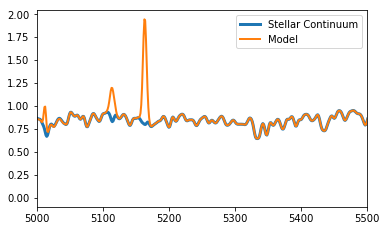

vel_z 9227.7566181 9371.2427


/Users/beckynevin/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(4563,)


In [257]:
plt.clf()
path_spec='MaNGA_J0749/manga-8141-1901-LOGCUBE-VOR10-GAU-MILESHC.fits'
#I need to get the VOR version: manga-8459-3702-LOGCUBE-VOR10-GAU-MILESHC.fits
'''
0	PRIMARY	Empty extension with primary header information.
1	FLUX	Flux of the binned spectra (10(-17) erg/s/cm2/angstrom/spaxel)
2	IVAR	Inverse variance in the binned spectra, accounting for covariance
3	MASK	Bitmask for the binned and model spectra
4	WAVE	Wavelength vector (angstroms)
5	REDCORR	Reddening correction applied during the fitting procedures; dereddened_flux = FLUX * REDCORR
6	MODEL	The best fitting model spectra (sum of the fitted continuum and emission-line models; 10(-17) erg/s/cm2/angstrom/spaxel)
7	EMLINE	The model spectrum with only the emission lines (10(-17) erg/s/cm2/angstrom/spaxel)
8	EMLINE_BASE	The model of the constant baseline fitted beneath the emission lines (10(-17) erg/s/cm2/angstrom/spaxel)
9	EMLINE_MASK	The bitmask that only applies to the emission-line modeling.
'''
logcube=pyfits.open(path_spec)
print('entire header', logcube[0].header)

print('DAP VERSION', logcube[0].header['VERSDAP'])

print('REFF', logcube[0].header['REFF'])
#print('Binning?', logcube[0].header['BINTYPE'])
print('SN min in fit', logcube[0].header['SCMINSN'])
print('Input Vel', logcube[0].header['SCINPVEL'])
print('Input Sigma', logcube[0].header['SCINPSIG'])
print('Number of Stellar Templates', logcube[0].header['NSCMOD'])
print('Type of Fitting', logcube[0].header['SCTYPE'])
print('PpXF? ', logcube[0].header['SCMETH'])
print('Template lib', logcube[0].header['PPXFTPLK'])
print('Bias value', logcube[0].header['PPXFBIAS'])
print('Cleaned?', logcube[0].header['PPXFCLN'])
print('Moments', logcube[0].header['PPXFMOM'])
print('Polynomial Degree', logcube[0].header['PPXFDEG'])
print('Multiplicative Polynomial Degree', logcube[0].header['PPXFMDEG'])

stellar_cont=logcube[6].data-logcube[7].data-logcube[8].data
plt.plot(logcube[4].data,stellar_cont[:,20,20],lw=3, label='Stellar Continuum')
plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=2, label='Model')
plt.legend()
plt.xlim([5000,5500])
plt.show()

xs=logcube[4].data
ys=logcube[1].data[:,20,20]
noise=logcube[2].data[:,20,20]
mask=logcube[3].data[:,20,20]

tens=np.linspace(1,10,10)


def gauss_2line(x, *p):
    A, mu, sigma,A2, mu2, sigma2,a,  b = p
    return a*x+b+A*numpy.exp(-(x-mu)**2/(2.*sigma**2))+A2*numpy.exp(-(x-mu2)**2/(2.*sigma2**2))

def gauss_line(x, *p):
    A, mu, sigma,a,  b = p
    return a*x+b+A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

#first, redshift correct z = 0.0313
#redshift_J0750 = 0.0315085915911

input_z=0.0313
input_z = 0.0315085915911
input_z = 0.0312591
c = 299792.458
vel_z = c*np.log(1 + input_z) 

print('vel_z', vel_z, logcube[0].header['SCINPVEL'])
length=len(logcube[1].data[1][0])
plot='no'

velocity_offset=np.zeros((length,length))
aik_1=np.zeros((length,length))
velocity_offset_2_1=np.zeros((length,length))
velocity_offset_2_2=np.zeros((length,length))
aik_2=np.zeros((length,length))



for i in range(length):#len(tens)
    for j in range(length):
        xs_fit=xs[1520:1600]
        ys=logcube[1].data[:,i,j]
        ys_fit=ys[1520:1600]
        
        
        p0=[max(ys_fit),5008.24+5008.24*(vel_z/c),5,0,0.2]#5008.24+5008.24*(vel/c)+5
        coeff=curve_fit(gauss_line,xs_fit,ys_fit,p0=p0)[0]
      
        
        '''
        Do it the same as in the W_80 code:
        vel_one.append(c*np.log(((vel_1[j]+wavelength_center-interval)*CDELT1+CRVAL1-lab_lambda)/lab_lambda+1))
    
        kilos.append((vel_one[j]+V_HELIO-vel_stars)/(1.+z_ossy))#relativistic velocity offset
        '''
        offset_v=(c*np.log(1+(coeff[1]-5008.24)/5008.24)-vel_z)/(1.+input_z)
        #print('offset_v', offset_v)
        velocity_offset[i][j]=offset_v
        fit=gauss_line(xs_fit,*coeff)
        
        
        params=5
        length_pix=len(xs_fit)
        dof=length_pix-1-params
        ans_gauss=chisquare(ys_fit, fit, ddof=params)
        
        aik_1[i][j]=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
        aikk_1=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
        
        if plot=='yes':
            plt.plot(xs_fit, ys_fit, label='Data')
            plt.plot(xs_fit, fit, label='1 Gauss')
        '''Also, fit two gauss and see which is better according to akaike stats'''
        try:
        
            p0=[coeff[0]/2,coeff[1]-3,coeff[2]/2,coeff[0]/2,coeff[1]+3,coeff[2]/2,coeff[3],coeff[4]]#5008.24+5008.24*(vel/c)+5
            coeff_2=curve_fit(gauss_2line,xs_fit,ys_fit,p0=p0)[0]


            '''
            Do it the same as in the W_80 code:
            vel_one.append(c*np.log(((vel_1[j]+wavelength_center-interval)*CDELT1+CRVAL1-lab_lambda)/lab_lambda+1))

            kilos.append((vel_one[j]+V_HELIO-vel_stars)/(1.+z_ossy))#relativistic velocity offset
            '''
            offset_v_1=(c*np.log(1+(coeff_2[1]-5008.24)/5008.24)-vel_z)/(1.+input_z)
            offset_v_2=(c*np.log(1+(coeff_2[4]-5008.24)/5008.24)-vel_z)/(1.+input_z)
            #print('offset_v', offset_v)
            if offset_v_1 < offset_v_2:
                offset_blue=offset_v_1
                offset_red=offset_v_2
            else:
                offset_blue=offset_v_2
                offset_red=offset_v_1
            velocity_offset_2_1[i][j]=offset_blue# this one is the bluer component
            velocity_offset_2_2[i][j]=offset_red# this one is the redder component
            fit=gauss_2line(xs_fit,*coeff_2)
            
            coeff_3=[coeff_2[0],coeff_2[1],coeff_2[2],coeff_2[6],coeff_2[7]]
            fit_1=gauss_line(xs_fit,*coeff_3)
            
            coeff_4=[coeff_2[3],coeff_2[4],coeff_2[5],coeff_2[6],coeff_2[7]]
            fit_2=gauss_line(xs_fit,*coeff_4)

            '''Also, fit two gauss and see which is better according to akaike stats'''
            params=8
            length_pix=len(xs_fit)
            dof=length_pix-1-params
            ans_gauss=chisquare(ys_fit, fit, ddof=params)

            aik_2[i][j]=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
            aikk_2=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
            
            if plot=='yes':
             
                plt.plot(xs_fit, fit, label='2 Gauss')
                plt.plot(xs_fit, fit_1, label='2 Gauss 1')
                plt.plot(xs_fit, fit_2, label='2 Gauss 2')
        except RuntimeError:
            aik_2[i][j]=10000
            aikk_2=10000
            velocity_offset_2_1[i][j]=10000
            velocity_offset_2_2[i][j]=10000
        if coeff_2[0] < 0 or coeff_2[3] < 0:
            #print('coeff_2', coeff_2)
            aik_2[i][j]=10000
            aikk_2=10000
            velocity_offset_2_1[i][j]=10000
            velocity_offset_2_2[i][j]=10000
            
        '''if aikk_1 < aikk_2:
            velocity_offset_2_1[i][j]=10000
            velocity_offset_2_2[i][j]=10000'''
            
        if plot=='yes':
            plt.legend()
            plt.show()
        plt.clf()
            
        

masked_vel_2_1=ma.masked_where(velocity_offset_2_1 > 9999 , velocity_offset_2_1)
masked_vel_2_2=ma.masked_where(velocity_offset_2_2 > 9999 , velocity_offset_2_2)


masked_velocity_offset=ma.masked_where(velocity_offset == velocity_offset[0][0] , velocity_offset)
print(shape(mask))

In [258]:
path_spec='MaNGA_J0749/manga-8141-1901-MAPS-VOR10-GAU-MILESHC.fits'
#path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
b=pyfits.open(path_spec)

print(b[0].header)
data_stel_vel=b['STELLAR_VEL'].data

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.title(r'H$\beta$ Flux')
im = ax.imshow(np.flipud(masked_velocity_offset)-np.flipud(data_stel_vel)+25.89, vmin=-150, vmax=150, interpolation='None', cmap='rainbow')
ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)

ax.set_title(r'Residuals ([OIII]] - Stellar)', size=20)
plt.tight_layout()
savefig('diff_stel_vel_one_gauss.pdf')


plt.clf()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.title(r'H$\beta$ Flux')
im = ax.imshow(np.flipud(masked_velocity_offset), vmin=-150, vmax=150, cmap='rainbow')
ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)


ax.set_title('One Gaussian', size=20)
plt.tight_layout()

savefig('J0749_MaNGA_1_gauss.pdf')
plt.clf()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.title(r'H$\beta$ Flux')
im = ax.imshow(np.flipud(masked_vel_2_1), vmin=-150, vmax=150, cmap='rainbow')
ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)


ax.set_title('Two Gaussian 1 Bluer Component', size=20)
plt.tight_layout()
savefig('J0749_MaNGA_2_1_gauss.pdf')
plt.clf()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.title(r'H$\beta$ Flux')
im = ax.imshow(np.flipud(masked_vel_2_2), vmin=-150, vmax=150, cmap='rainbow')
ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)




ax.set_title('Two Gaussian 2 Redder Component', size=20)
plt.tight_layout()
savefig('J0749_MaNGA_2_2_gauss.pdf')

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  AUTHOR  = 'K Westfall, B Andrews <kyle.westfall@port.co.uk, andrewsb@pitt.edu>' VERSDRP2= 'v2_0_1  '           / MaNGA DRP version (2d processing)              VERSDRP3= 'v2_0_1  '           / MaNGA DRP Version (3d processing)              VERSPLDS= 'v2_52   '           / Platedesign Version                            VERSFLAT= 'v1_26   '           / Specflat Version                               VERSCORE= 'v1_3_1  '           / MaNGAcore Version                              VERSPRIM= 'v2_2    '           / MaNGA Preimaging Version                       VERSUTIL= 'v5_5_25 '           / Version of idlutils                            VERSIDL = 'x86_64 linux unix linux 7.1.1

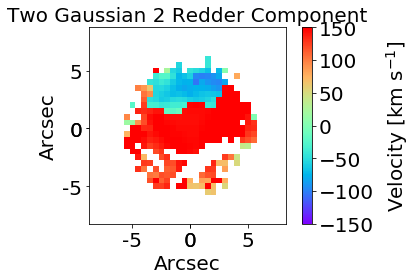

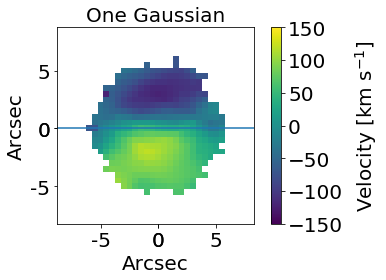

/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:3213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


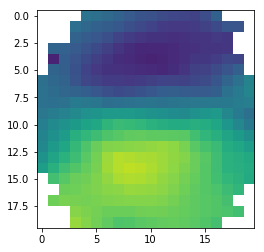

/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


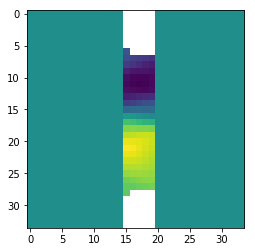

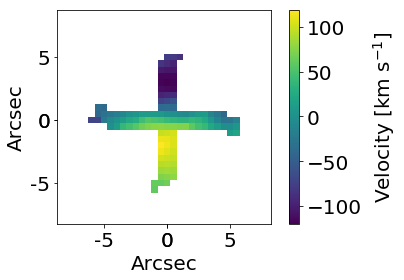

In [15]:
'''Now I need to extract velocities according to the longslit data'''

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.title(r'H$\beta$ Flux')
im = ax.imshow(np.flipud(masked_velocity_offset), vmin=-150, vmax=150)
ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)


ax.set_title('One Gaussian', size=20)
plt.tight_layout()
plt.axhline(y=middle)

plt.show()

'''You need to identify the spaxels by location'''
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(np.flipud(masked_velocity_offset)[len(data_stel_vel)/2-10:len(data_stel_vel)/2+10,len(data_stel_vel)/2-10:len(data_stel_vel)/2+10], vmin=-150, vmax=150)
plt.show()

'''Maybe you need to make a new image composed of masks'''

new_image=np.zeros([len(data_stel_vel), len(data_stel_vel)])

for i in range(len(data_stel_vel)):
    for j in range(len(data_stel_vel)):
        if j > len(data_stel_vel)/2-3 and j < len(data_stel_vel)/2+3:
            new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]
plt.imshow(new_image)
plt.show()


'''Now try with some slope'''

new_image=np.zeros([len(data_stel_vel), len(data_stel_vel)])

slope=np.tan(math.radians(90-87))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-87))

for i in range(len(data_stel_vel)):
    for j in range(len(data_stel_vel)):
        if i > slope*j+offset-height and i < slope*j+offset+height:
            new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]
            
slope=np.tan(math.radians(90-177))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-177))

for i in range(len(data_stel_vel)):
    for j in range(len(data_stel_vel)):
        if i > slope*j+offset-height and i < slope*j+offset+height:
            new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]

            
            
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

masked_new_image=ma.masked_where(new_image == 0, new_image)
im=ax.imshow(masked_new_image)
#plt.axhline(y=(middle) , color='white')
#plt.axvline(x=(middle), color='white')


ax.set_adjustable('box-forced')

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(data_stel_vel)/2,10)
middle=len(data_stel_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=20)

cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')

cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=20,weight='normal', labelpad=10)





#plt.xlim([0,len(data_stel_vel)])
#plt.ylim([0,len(data_stel_vel)])
plt.xlabel('Arcsec', size=20)
plt.ylabel('Arcsec', size=20)


#plt.xlim([len(data_stel_vel)/2+10,len(data_stel_vel)/2-10])
#plt.ylim([len(data_stel_vel)/2+10,len(data_stel_vel)/2-10])
plt.tight_layout()



plt.show()



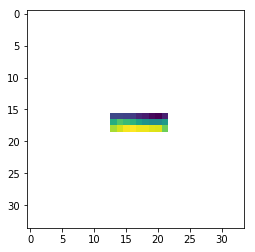

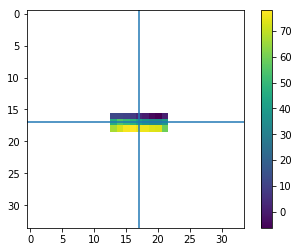

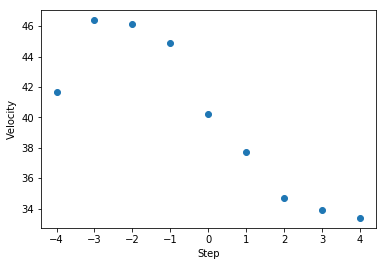

In [241]:
'''Now, that weve made a swastika, now time to bin into the 0.5arcsec pixels (for PA 87)'''
plt.clf()
plt.imshow(masked_new_image)
plt.show()

new_image=np.zeros([len(data_stel_vel), len(data_stel_vel)])

slope=np.tan(math.radians(90-87))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-87))

step=np.linspace(-4,4,9)#positive steps to right, negative to left
#step=np.linspace(0,0,1)
spatial_position=[]
vel_mean=[]
counter=0


for k in range(len(step)):
    vel=[]

    for i in range(len(data_stel_vel)):
        for j in range(len(data_stel_vel)):
            
            

            if i > slope*j+offset-height and i < slope*j+offset+height and j < len(data_stel_vel)/2+1+step[k] and j > len(data_stel_vel)/2-1+step[k]:
                spatial_position.append(0.5*step[k])
                vel.append((np.flipud(masked_velocity_offset)[i,j]))
                new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]
                
    vel_mean.append(np.mean(vel))
    

'''slope=np.tan(math.radians(90-177))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-177))

for i in range(len(data_stel_vel)):
    for j in range(len(data_stel_vel)):
        if i > slope*j+offset-height and i < slope*j+offset+height:
            new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]'''
masked_new_image=ma.masked_where(new_image == 0, new_image)
plt.axhline(y=middle)
plt.axvline(x=middle)
plt.imshow(masked_new_image)
plt.colorbar()
plt.show()

'''plt.scatter(spatial_position, vel)
plt.show()
print(spatial_position)'''

'''step_arc=step*0.5
vel_mean=[]

for i in range(len(step_arc)):
    vel_all=[]
    for j in range(len(spatial_position)):
        if spatial_position[j] == step_arc[i]:
            vel_all.append(vel[j])
    vel_mean.append(mean(vel_all))'''
    
plt.scatter(step,vel_mean)
plt.xlabel('Step')
plt.ylabel('Velocity')
plt.show()
            
            

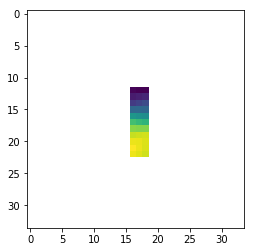

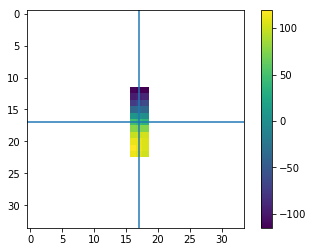

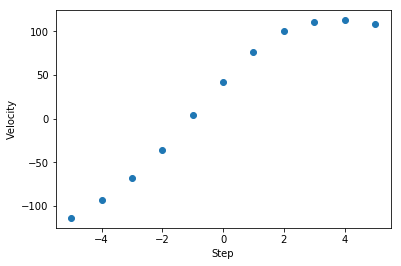

In [234]:
'''Now, that weve made a swastika, now time to bin into the 0.5arcsec pixels (for PA 87)'''

plt.imshow(masked_new_image)
plt.show()

new_image=np.zeros([len(data_stel_vel), len(data_stel_vel)])

slope=np.tan(math.radians(90-177))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-177))

step=np.linspace(-5,5,11)#positive steps to right, negative to left
#step=np.linspace(0,0,1)
spatial_position=[]
vel_mean=[]
counter=0


for k in range(len(step)):
    vel=[]

    for i in range(len(data_stel_vel)):
        for j in range(len(data_stel_vel)):
            
            

            if i > slope*j+offset-height and i < slope*j+offset+height and i < len(data_stel_vel)/2+1+step[k] and i > len(data_stel_vel)/2-1+step[k]:
                spatial_position.append(0.5*step[k])
                vel.append((np.flipud(masked_velocity_offset)[i,j]))
                new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]
                
    vel_mean.append(np.mean(vel))
    

'''slope=np.tan(math.radians(90-177))
offset=len(data_stel_vel)/2-slope*len(data_stel_vel)/2
height=1.5/np.sin(math.radians(180-177))

for i in range(len(data_stel_vel)):
    for j in range(len(data_stel_vel)):
        if i > slope*j+offset-height and i < slope*j+offset+height:
            new_image[i,j]=np.flipud(masked_velocity_offset)[i,j]'''
masked_new_image=ma.masked_where(new_image == 0, new_image)
plt.axhline(y=middle)
plt.axvline(x=middle)
plt.imshow(masked_new_image)
plt.colorbar()
plt.show()

'''plt.scatter(spatial_position, vel)
plt.show()
print(spatial_position)'''

'''step_arc=step*0.5
vel_mean=[]

for i in range(len(step_arc)):
    vel_all=[]
    for j in range(len(spatial_position)):
        if spatial_position[j] == step_arc[i]:
            vel_all.append(vel[j])
    vel_mean.append(mean(vel_all))'''
    
plt.scatter(step,vel_mean)
plt.xlabel('Step')
plt.ylabel('Velocity')
plt.show()
            
            

In [239]:
plt.clf()

ax = plt.subplot(111)

data_stel_vel=b['STELLAR_VEL'].data#'STELLAR_VEL'
data_stel_vel_ivar=b['STELLAR_VEL_IVAR'].data
data_stel_vel_mask=b['STELLAR_VEL_MASK'].data

masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
masked_stel_vel=ma.masked_where(data_stel_vel > 1000, masked_stel_vel)
#plt.show()
#plt.clf()

ax.imshow((masked_stel_vel-25.89), vmin=-150, vmax=150, cmap='rainbow')#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel))#, interpolation='None')#, vmin=-300, vmax=300)


#step_arc and vel_mean
print('step', step)
arc_x_111=[-math.sin(math.radians(-87))*0.5*x for x in step]
arc_y_111=[-math.cos(math.radians(-87))*0.5*x for x in step]
    
    
ws = [1.5 for x in vel_mean]
hs = [0.5 for x in vel_mean]

mini=min(vel_mean)
maxi=max(vel_mean)
print('min max PA 2', mini,maxi)

#mini=-300
#maxi=100

normal = [(x-mini)/(maxi-mini) for x in vel_mean]
colors =normal#(vel_1_ortho[low_111:high_111])
'''colors=pl.cm.jet(vel_2_1)
print(arc_x_21[low_21:high_21])
print(colors)'''

patch=[]
for x,y,w,h,c in zip(arc_x_111,arc_y_111,ws,hs,colors):
    corr_x=-1.5/2
    corr_y=-0.5/2
    #corr_x=0
    #corr_y=0
    c=plt.cm.jet(c)
    
    rect = plt.Rectangle((x+corr_x,y+corr_y),w,h,color=c, alpha=0.5)
    
    '''t_start=ax.transData
    t = mpl.transforms.Affine2D().rotate_deg(-45) + ax.transData
    t_end = t_start + t
    rect.set_transform(t_end)'''
    
  
    tr = mpl.transforms.Affine2D().rotate_deg_around(x, y, 87)+ax.transData
    rect.set_transform(tr)
    patch.append(rect)

    ax.add_patch(rect)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5,5])
plt.ylim([-5,5])

from matplotlib.collections import PatchCollection
p = PatchCollection(patch,alpha=0.5)
    
    
p.set(array=normal, cmap=plt.cm.jet)
#axs[counter].add_collection(p)

tickz=[0,0.2,0.4,0.6,0.8,1.0]
ticklbls=[int(x*(maxi-mini)+mini) for x in tickz]

cbar=plt.colorbar(p,ax=ax,shrink=0.5,pad=-0.1, ticks=tickz)
#cbar.set_clim(-1,1)


cbar.ax.set_yticklabels(ticklbls)

plt.scatter(0,0, marker='x')
#how to set colorbar labels? (When the scale is normalized)
'''mini=min(vel_1_ortho[low_111:high_111])
maxi=max(vel_1_ortho[low_111:high_111])

normal = [(x-mini)/(maxi-mini) for x in vel_1_ortho[low_111:high_111]]'''
savefig('../my_pseudo_ifu_comp_1_J0749_m_1.pdf')

#plt.show()

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


step [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
min max PA 2 33.3964952107 46.3741597356


In [275]:
'''I would like to make the 3x3 profile maps for the OIII profiles (for PA 87 here)'''
plt.clf()
xs=logcube[4].data
'''ys=logcube[1].data[:,20,20]
noise=logcube[2].data[:,20,20]
mask=logcube[3].data[:,20,20]'''



#input_z=0.0313
input_z = 0.0315085915911
input_z = 0.0312591
c = 299792.458
vel_z = c*np.log(1 + input_z) 
length=len(logcube[1].data[1][0])
plot='no'


'''for i in range(length):#len(tens)
    for j in range(length):
        xs_fit=xs[1520:1600]
        ys=logcube[1].data[:,i,j]
        ys_fit=ys[1520:1600]'''
        
        
        
'''Transitioning from a swastika to a profile swastika'''



slope=np.tan(math.radians(90-87))
offset=length/2-slope*length/2
height=1.5/np.sin(math.radians(180-87))

step=np.linspace(-4,4,9)#positive steps to right, negative to left
#step=np.linspace(0,0,1)
spatial_position=[]

counter=0

fig, axs = plt.subplots(3,3, figsize=(20, 20), facecolor='w', edgecolor='r', sharex=True)
fig.subplots_adjust(hspace = .10, wspace=.20)
counter=0
axs = axs.ravel()


for k in range(len(step)):
    
    oiii_prof=[]

    for i in range(length):
        for j in range(length):
            xs_fit=xs[1520:1600]
            ys=logcube[1].data[:,i,j]
            ys_fit=ys[1520:1600]

            '''plt.plot(xs_fit,ys_fit)
            plt.show()
            plt.clf()'''

            if i > slope*j+offset-height and i < slope*j+offset+height and j < length/2+1+step[k] and j > length/2-1+step[k]:
                spatial_position.append(0.5*step[k])
                oiii_prof.append(ys_fit)
                #oiii_prof_lambdas.append(xs_fit)
    summed_prof=np.sum(oiii_prof,axis=0)
    offset_v=[(c*np.log(1+(x-5008.24)/5008.24)-vel_z)/(1.+input_z) for x in xs_fit]
    
    
    
    p0=[max(summed_prof),5008.24+5008.24*(vel_z/c),5,0,0.2]#5008.24+5008.24*(vel/c)+5
    coeff=curve_fit(gauss_line,xs_fit,summed_prof,p0=p0)[0]

    fit=gauss_line(xs_fit,*coeff)
        
        
    '''params=5
    length_pix=len(xs_fit)
    dof=length_pix-1-params
    ans_gauss=chisquare(summed_prof, fit, ddof=params)
        
    aik_1[i][j]=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
    aikk_1=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)'''
    axs[counter].plot(offset_v, fit,color='cornflowerblue', linewidth=3)
    
    try:

        p0=[coeff[0]/2,coeff[1]-3,coeff[2]/2,coeff[0]/2,coeff[1]+3,coeff[2]/2,coeff[3],coeff[4]]#5008.24+5008.24*(vel/c)+5
        coeff_2=curve_fit(gauss_2line,xs_fit,summed_prof,p0=p0)[0]


        
        fit=gauss_2line(xs_fit,*coeff_2)

        coeff_3=[coeff_2[0],coeff_2[1],coeff_2[2],coeff_2[6],coeff_2[7]]
        fit_1=gauss_line(xs_fit,*coeff_3)

        coeff_4=[coeff_2[3],coeff_2[4],coeff_2[5],coeff_2[6],coeff_2[7]]
        fit_2=gauss_line(xs_fit,*coeff_4)

        
        
        axs[counter].plot(offset_v, fit_1, ls='--', color='blue', lw=2)
        axs[counter].plot(offset_v, fit_2, ls='--', color='red', lw=2)
        axs[counter].plot(offset_v, fit, color='magenta', lw=4)
    except RuntimeError:
        aik_2[i][j]=10000
        aikk_2=10000
        velocity_offset_2_1[i][j]=10000
        velocity_offset_2_2[i][j]=10000
    if coeff_2[0] < 0 or coeff_2[3] < 0:
        #print('coeff_2', coeff_2)
        aik_2[i][j]=10000
        aikk_2=10000
        velocity_offset_2_1[i][j]=10000
        velocity_offset_2_2[i][j]=10000
    
    
    
    
    
    axs[counter].plot(offset_v,np.sum(oiii_prof,axis=0), lw=3, color='black')
    axs[counter].annotate(str(0.5*step[k])+r'$^{\prime\prime}$', xy=(0.03,0.90), xycoords='axes fraction', size=20)
    plt.xlim([-810,810])
    axs[counter].axvline(x=0, color='black', ls='-.')
    
    axs[counter].set_ylim([0,max(np.sum(oiii_prof,axis=0))+2])
    axs[counter].set_ylim([1,17])
            #plt.get_yaxis().set_ticks([0, 20])
    axs[counter].get_xaxis().set_ticks([-500,0,500])
    fig.text(0.51, 0.05, r'Velocity [km s$^{-1}$]', ha='center', size=30)
    fig.text(0.05, 0.5, 'Relative Intensity', va='center', rotation='vertical', size=30)
    #fig.text(0.51, 0.93, str(tit), ha='center', size=30)
    
    
    counter+=1
    
savefig('../fake_longslit_PA_87_Gaussfit.pdf')
plt.clf()

print('done')
    
    #vel_mean.append(np.mean(vel))

done


In [276]:
'''Now doing the same thing for PA 177, very exciting'''
'''I would like to make the 3x3 profile maps for the OIII profiles (for PA 87 here)'''
plt.clf()
xs=logcube[4].data
'''ys=logcube[1].data[:,20,20]
noise=logcube[2].data[:,20,20]
mask=logcube[3].data[:,20,20]'''



#input_z=0.0313
input_z = 0.0315085915911
input_z = 0.0312591
c = 299792.458
vel_z = c*np.log(1 + input_z) 
length=len(logcube[1].data[1][0])
plot='no'


'''for i in range(length):#len(tens)
    for j in range(length):
        xs_fit=xs[1520:1600]
        ys=logcube[1].data[:,i,j]
        ys_fit=ys[1520:1600]'''
        
        
        
'''Transitioning from a swastika to a profile swastika'''



slope=np.tan(math.radians(90-177))
offset=length/2-slope*length/2
height=1.5/np.sin(math.radians(180-177))

step=np.linspace(-4,4,9)#positive steps to right, negative to left
#step=np.linspace(0,0,1)
spatial_position=[]

counter=0

fig, axs = plt.subplots(3,3, figsize=(20, 20), facecolor='w', edgecolor='r', sharex=True)
fig.subplots_adjust(hspace = .10, wspace=.20)
counter=0
axs = axs.ravel()


for k in range(len(step)):
    
    oiii_prof=[]

    for i in range(length):
        for j in range(length):
            xs_fit=xs[1520:1600]
            ys=logcube[1].data[:,i,j]
            ys_fit=ys[1520:1600]

            '''plt.plot(xs_fit,ys_fit)
            plt.show()
            plt.clf()'''

            if i > slope*j+offset-height and i < slope*j+offset+height and i < len(data_stel_vel)/2+1+step[k] and i > len(data_stel_vel)/2-1+step[k]:
                spatial_position.append(0.5*step[k])
                oiii_prof.append(ys_fit)
                #oiii_prof_lambdas.append(xs_fit)
    summed_prof=np.sum(oiii_prof,axis=0)
    offset_v=[(c*np.log(1+(x-5008.24)/5008.24)-vel_z)/(1.+input_z) for x in xs_fit]
    
    
    
    p0=[max(summed_prof),5008.24+5008.24*(vel_z/c),5,0,0.2]#5008.24+5008.24*(vel/c)+5
    coeff=curve_fit(gauss_line,xs_fit,summed_prof,p0=p0)[0]

    fit=gauss_line(xs_fit,*coeff)
        
        
    '''params=5
    length_pix=len(xs_fit)
    dof=length_pix-1-params
    ans_gauss=chisquare(summed_prof, fit, ddof=params)
        
    aik_1[i][j]=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)
    aikk_1=ans_gauss[0]+2*params+(2*params*(params+1))/(dof)'''
    axs[counter].plot(offset_v, fit,color='cornflowerblue', linewidth=3)
    
    try:

        p0=[coeff[0]/2,coeff[1]-3,coeff[2]/2,coeff[0]/2,coeff[1]+3,coeff[2]/2,coeff[3],coeff[4]]#5008.24+5008.24*(vel/c)+5
        coeff_2=curve_fit(gauss_2line,xs_fit,summed_prof,p0=p0)[0]


        
        fit=gauss_2line(xs_fit,*coeff_2)

        coeff_3=[coeff_2[0],coeff_2[1],coeff_2[2],coeff_2[6],coeff_2[7]]
        fit_1=gauss_line(xs_fit,*coeff_3)

        coeff_4=[coeff_2[3],coeff_2[4],coeff_2[5],coeff_2[6],coeff_2[7]]
        fit_2=gauss_line(xs_fit,*coeff_4)

        
        
        axs[counter].plot(offset_v, fit_1, ls='--', color='blue', lw=2)
        axs[counter].plot(offset_v, fit_2, ls='--', color='red', lw=2)
        axs[counter].plot(offset_v, fit, color='magenta', lw=4)
    except RuntimeError:
        aik_2[i][j]=10000
        aikk_2=10000
        velocity_offset_2_1[i][j]=10000
        velocity_offset_2_2[i][j]=10000
    if coeff_2[0] < 0 or coeff_2[3] < 0:
        #print('coeff_2', coeff_2)
        aik_2[i][j]=10000
        aikk_2=10000
        velocity_offset_2_1[i][j]=10000
        velocity_offset_2_2[i][j]=10000
    
    
    
    
    
    axs[counter].plot(offset_v,np.sum(oiii_prof,axis=0), lw=3, color='black')
    axs[counter].annotate(str(0.5*step[k])+r'$^{\prime\prime}$', xy=(0.03,0.90), xycoords='axes fraction', size=20)
    plt.xlim([-810,810])
    axs[counter].axvline(x=0, color='black', ls='-.')
    
    axs[counter].set_ylim([0,max(np.sum(oiii_prof,axis=0))+2])
    axs[counter].set_ylim([1,17])
            #plt.get_yaxis().set_ticks([0, 20])
    axs[counter].get_xaxis().set_ticks([-500,0,500])
    fig.text(0.51, 0.05, r'Velocity [km s$^{-1}$]', ha='center', size=30)
    fig.text(0.05, 0.5, 'Relative Intensity', va='center', rotation='vertical', size=30)
    #fig.text(0.51, 0.93, str(tit), ha='center', size=30)
    
    
    counter+=1
    
savefig('../fake_longslit_PA_177_Gaussfit.pdf')
plt.clf()

print('done')
    
    #vel_mean.append(np.mean(vel))




done


[33]


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:159: RuntimeWarning: invalid value encountered in sqrt


counter 402


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:194: RuntimeWarning: divide by zero encountered in double_scalars
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:196: RuntimeWarning: divide by zero encountered in double_scalars


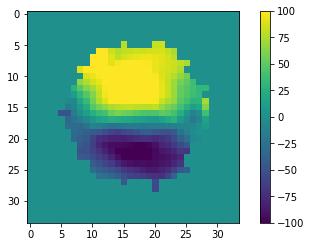

NameError: name 'stop' is not defined

In [224]:
#an alternate idea





plate_list=['8141']
fiber_list=['1901']


#plate_list=['8086']
#fiber_list=['12705']#46,54



xcoord_list=[33 for x in plate_list]
ycoord_list=[23 for x in plate_list]
print(xcoord_list)

kinemetry_gas('8141','1901')
stop
kinemetry('8141','1901')
stop

plot_BPTs(plate_list, fiber_list)



y=plot_all(plate_list, fiber_list,'no','yes','no', xcoord_list,ycoord_list)
oiii_vel=y[0]

'''def plot_all(plate_list, fiber_list, Circle, Stellar, Write)
Theres an option to turn stellar on or off (ie if you don't have any default files for that galaxy,
Likewise, write creates an r-band image'''
'''last two entries are xcoord and ycoord, we need to make these into a list'''

print('Length check',len(plate_list), len(fiber_list))


#file = open("../MaNGA/Table_BLR_pos.txt", "w")
#file.write('Plate_ID Fiber_ID AVG_sig_BLR'+'\n')



In [64]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


plt.clf()


cmap = colors.ListedColormap(['k','b','y','g','r'])

def LIER(x):
    return 0.9*x+0.48
    
def kewley(x):
    return (0.61/(x-0.47))+1.19

def kauffman(x):
    return (0.61/(x-0.05))+1.3

def SII_AGN(x):
    return (0.72/(x-0.32))+1.3

def SII_LINER(x):
    return 1.89*x + 0.76

def OI_AGN(x):
    return 0.73/(x + 0.59)+1.33

def OI_LINER(x):
    return 1.18*x+1.30



In [65]:
def plot_BPTs(plate_list, fiber_list):
  
    
    plt.clf()
    for i in range(len(plate_list)):
        
        correction=2
        plate=plate_list[i]
        fiber=fiber_list[i]
        
        
        #opening the file for the r-band magnitude
        path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
        b=pyfits.open(path_spec)
        #print(b[0].header)
        
        '''Time to make some BPT diagrams'''
        '''Sflux is the summed flux (no Gaussian fit)'''
        data_elines = b['EMLINE_SFLUX'].data 
        data_elines_mask = b['EMLINE_SFLUX_MASK'].data
        data_elines_ivar = b['EMLINE_SFLUX_IVAR'].data
        
        data_stel_vel= data_elines[1]
        
        
        #Make all three plots = why not?
        #1 = Hb
        #3 = OIII
        #4 = OI 6300
        #7 = Ha 6564
        #8 = NII 6583
        #9 = SII 6718
        #10 = SII 6732 (add these two for the SII diagnostic)
        
        error_index=[1,3,8,7,9,10,4]
        name_errors=['H_beta','OIII','NII','H_alpha','SIIa','SIIb', 'OI']
        emission_index=[1,3,8,7,9,10,4]
        labels=[r'H$\beta$ Flux / arcsec$^2$',r'[OIII] Flux / arcsec$^2$',r'[NII] Flux / arcsec$^2$',r'H$\alpha$ Flux / arcsec$^2$',r'[SII]b Flux / arcsec$^2$',r'[SII]b Flux / arcsec$^2$',r'[OI] Flux / arcsec$^2$']
        name_file=['hbeta','oiii','nii','halpha','siia','siib','oi']
        
        for k in range(len(name_errors)):
            plt.clf()
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            #plt.title(r'H$\beta$ Flux')
            im = ax.imshow(10*data_elines[emission_index[k]],norm=LogNorm(vmin=0.001, vmax=10*data_elines[emission_index[k]].max()), interpolation='None')
            ax.set_adjustable('box-forced')
                
            ax.get_yaxis().set_ticks_position("left")
            ax.get_xaxis().set_ticks_position("bottom")
            ax.get_yaxis().set_tick_params(direction='out')
            ax.get_xaxis().set_tick_params(direction='out')
            #put ticks every 5
            
            x_ticks=np.arange(0,len(data_stel_vel)/2,10)
            middle=len(data_stel_vel)/2
            #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)
                
            x_tick_locs_neg=[middle-x for x in x_ticks]
            x_tick_locs_pos=[middle+x for x in x_ticks]
            x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
            
            x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
            y_tick_lbls=[-x for x in x_tick_lbls]
            
            ax.xaxis.set_ticks(x_tick_locs)
            ax.xaxis.set_ticklabels(x_tick_lbls, size=20)
            
            ax.yaxis.set_ticks(x_tick_locs)
            ax.yaxis.set_ticklabels(y_tick_lbls, size=20)
            
            cbar1=colorbar(im)
            cbar1.ax.tick_params(labelsize=20, direction='out')
    
            cbar1.set_label(label=r'[10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]',size=25,weight='normal', labelpad=10)
            
            
            
            
            
            #plt.xlim([0,len(data_stel_vel)])
            #plt.ylim([0,len(data_stel_vel)])
            plt.xlabel('Arcsec', size=25)
            plt.ylabel('Arcsec', size=25)
            plt.tight_layout()
            savefig('MaNGA_J0749/'+plate+'_'+fiber+'_'+name_file[k]+'_flux.pdf')
        
        
 
        
        
        for k in range(len(name_errors)):
        
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            #plt.title(r'H$\alpha$ Error')
            im = ax.imshow(np.sqrt(1/data_elines_ivar[error_index[k]]),norm=LogNorm(vmin=0.001, vmax=np.sqrt(1/data_elines_ivar[error_index[k]].max())), interpolation='None')
            
            
            ax.set_adjustable('box-forced')
                
            ax.get_yaxis().set_ticks_position("left")
            ax.get_xaxis().set_ticks_position("bottom")
            ax.get_yaxis().set_tick_params(direction='out')
            ax.get_xaxis().set_tick_params(direction='out')
            
            x_tick_locs_neg=[middle-x for x in x_ticks]
            x_tick_locs_pos=[middle+x for x in x_ticks]
            x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
            
            x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
            y_tick_lbls=[-x for x in x_tick_lbls]
            
            ax.xaxis.set_ticks(x_tick_locs)
            ax.xaxis.set_ticklabels(x_tick_lbls, size=20)
            
            ax.yaxis.set_ticks(x_tick_locs)
            ax.yaxis.set_ticklabels(y_tick_lbls, size=20)
            cbar1=colorbar(im)
            cbar1.ax.tick_params(labelsize=20, direction='out')
            #colorbar(im)
            cbar1.set_label(label=r'Flux Error [10$^{-16}$ erg s$^{-1}$ cm$^{-2}$]',size=20,weight='normal', labelpad=10)
            #plt.colorbar(im, label=)
            #plt.xlim([0,len(data_stel_vel)])
            #plt.ylim([0,len(data_stel_vel)])
            plt.xlabel('Arcsec', size=25)
            plt.ylabel('Arcsec', size=25)
            plt.tight_layout()
            savefig('MaNGA_J0749/'+plate+'_'+fiber+'_'+name_errors[k]+'_flux_error.pdf')
            plt.clf()
        
        #
        
        
        '''Time to make a BPT diagram yo'''
        
        ratio_OIII_Hbeta=[]
        ratio_OIII_Hbeta_e=[]
        ratio_OIII_Hbeta_e_log=[]
        ratio_NII_Halpha=[]
        ratio_NII_Halpha_e=[]
        ratio_NII_Halpha_e_log=[]
        colorcode=[]
      
        
        #name_errors=['H_beta','OIII','NII','H_alpha']
        #1,3,8,7
        plt.clf()
        plt.imshow(data_elines_mask[3])
        
        savefig('MaNGA_J0749/'+plate+'_'+fiber+'_OIII_mask.pdf')
        
        color_2d=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        mask_2d=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        
        S_N_threshhold=1
        
        '''Step 1: Mask everything according to the individual emission line masks'''
        
        #1 = Hb
        #3 = OIII
        #4 = OI 6300
        #7 = Ha 6564
        #8 = NII 6583
        #9 = SII 6718
        #10 = SII 6732 (add these two for the SII diagnostic)
        
        for i in range(shape(data_elines[1])[0]):
            for j in range(shape(data_elines[1])[0]):
                percent_e_oiii=abs(np.sqrt(1/data_elines_ivar[3][i][j])/data_elines[3][i][j])
                percent_e_nii=abs(np.sqrt(1/data_elines_ivar[8][i][j])/data_elines[8][i][j])
                percent_e_hbeta=abs(np.sqrt(1/data_elines_ivar[1][i][j])/data_elines[1][i][j])
                percent_e_halpha=abs(np.sqrt(1/data_elines_ivar[7][i][j])/data_elines[7][i][j])
                percent_e_sii=abs(np.sqrt(1/(np.sqrt(data_elines_ivar[9][i][j]**2+data_elines_ivar[10][i][j]**2)))/(data_elines[9][i][j]+data_elines[10][i][j]))
                percent_e_oi=abs(np.sqrt(1/data_elines_ivar[4][i][j])/data_elines[4][i][j])
                
                if data_elines_mask[1][i][j]==0 and data_elines_mask[3][i][j]==0 and data_elines_mask[7][i][j]==0 and data_elines_mask[8][i][j]==0:
                    mask_2d[i][j]=0
                    OIII_Hbeta=np.log10(data_elines[3][i][j]/data_elines[1][i][j])
                    ratio_OIII_Hbeta.append(OIII_Hbeta)
                    
                    ratio_OIII_Hbeta_e.append((data_elines[3][i][j]/data_elines[1][i][j])*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    ratio_OIII_Hbeta_e_log.append(0.434*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    
                    NII_Halpha=np.log10(data_elines[8][i][j]/data_elines[7][i][j])
                    ratio_NII_Halpha.append(NII_Halpha)
                    ratio_NII_Halpha_e.append((data_elines[8][i][j]/data_elines[7][i][j])*(np.sqrt(percent_e_nii**2+percent_e_halpha**2)))
                    ratio_NII_Halpha_e_log.append(0.434*(np.sqrt(percent_e_nii**2+percent_e_halpha**2)))
                    
                    if kewley(NII_Halpha) < OIII_Hbeta or NII_Halpha > 0.5:
                        colorcode.append('r')
                        #print('red description', NII_Halpha, OIII_Hbeta)
                        #print('kewley(NII_Halpha)', kewley(NII_Halpha), 'LIER(NII_Halpha)', LIER(NII_Halpha))
                        color_2d[i][j]=10
                        #color_2d[i][j]='red'
                    else:
                        if kauffman(NII_Halpha) > OIII_Hbeta and NII_Halpha < 0.0 :# and NII_Halpha < 0.47:
                            colorcode.append('blue')
                            color_2d[i][j]=20
                        #color_2d[i][j]='blue'
                        else:
                            if OIII_Hbeta < kewley(NII_Halpha) and OIII_Hbeta > kauffman(NII_Halpha):#NII_Halpha > 0.47:
                                colorcode.append('orange')
                                color_2d[i][j]=13
                            else:
                                if OIII_Hbeta < kewley(NII_Halpha) and NII_Halpha > 0.05:
                                    colorcode.append('orange')
                                    color_2d[i][j]=13
                                else:
                                    colorcode.append('purple')
                else:
                    mask_2d[i][j]=1
          
        #log([OIII]/Hb) = 0.61 / (log([NII]/Ha) - 0.05) + 1.3     (Kauffmann+03 line)
        
        #log([OIII]/Hb) = 0.61 / (log([NII]/Ha) - 0.47) + 1.19    (Kewley+01 line)
        xs_kauff=np.linspace(-2.5,0.04,1000)
        ys_kauff=[(0.61/(y-0.05))+1.3 for y in xs_kauff]
        xs_kewley=np.linspace(-2.5,0.46,1000)
        ys_kewley=[(0.61/(y-0.47))+1.19 for y in xs_kewley]
        xs_LINER=np.linspace(-0.209,1.0, 1000)
        ys_LINER=[0.9*y+0.48 for y in xs_LINER]
        print('color_2d before mask', color_2d)
        
        color_2d = ma.masked_array(color_2d, mask=mask_2d)
        print('color_2d after mask', color_2d)
        #cmap = matplotlib.cm.get_cmap('jet')
        #norm = matplotlib.colors.Normalize(vmin=min(distance), vmax=max(distance))
        #distance=[float(y) for y in distance]
        #plt.plot(xs_kauff,ys_kauff, color='black')
        plt.clf()
        plt.plot(xs_kewley,ys_kewley, color='black', ls='--')
        plt.plot(xs_LINER, ys_LINER, color='black', ls='--')
        plt.plot(xs_kauff, ys_kauff, color='black', ls='--')
        cmap = colors.ListedColormap(colorcode)
        bounds=[0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        #plt.title('Poor Mans BPT PA 0')
        plt.xlabel(r'log [NII]$\lambda$6584/H$\alpha$',size=20)
        plt.ylabel(r'log [OIII]$\lambda$5007/H$\beta$',size=20)
        #plt.errorbar(ratio_NII_Halpha, ratio_OIII_Hbeta,yerr=ratio_OIII_Hbeta_e_log, xerr=ratio_NII_Halpha_e_log,ecolor='black', ls='None')# c=cmap(norm(distance)))#,edgecolors='none',s=100, marker='*')
        plt.scatter(ratio_NII_Halpha, ratio_OIII_Hbeta, c=colorcode,edgecolors='none',s=30,zorder=100)
        #cb1=plt.colorbar()
        
        #cb1.set_label('Distance [$^{\prime \prime}$] (Negative is S)', size=20)
        plt.ylim([-1.5,1.25])
        
        plt.xlim([-1.0,0.5])
        #plt.title('PA 0')
        plt.tight_layout()
        savefig('MaNGA_J0749/'+plate+'_'+fiber+'_bpt.pdf')
        plt.clf()
        
        plt.imshow(color_2d, vmin=10, vmax=20, cmap='RdYlBu', interpolation='none')
        
        #plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=15)
        plt.ylabel('Arcsec', size=15)
        savefig('MaNGA_J0749/'+plate+'_'+fiber+'_bpt_2d.pdf')
        plt.clf()
        
        '''Now I actually have to make the plots onto a huge figure'''
        img=mpimg.imread('MaNGA_J0749/img.png')
        fig = plt.figure(figsize=(30,20))
        fig.suptitle('Plate+Fiber'+' '+str(plate)+' '+str(fiber), fontsize=25)
        ax0 = fig.add_subplot(2,4,1, aspect='equal')
        im = ax0.imshow(np.flipud(img))
        plt.axis('off')
        
        ax1 = fig.add_subplot(2,4,2, aspect='equal')
        ax1.plot(xs_kewley,ys_kewley, color='black', ls='--')
        #ax1.plot(xs_LINER, ys_LINER, color='black', ls='--')
        ax1.plot(xs_kauff, ys_kauff, color='black', ls='--')
        ax1.set_aspect('auto')
        
        cmap = colors.ListedColormap(colorcode)
        bounds=[0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        #plt.title('Poor Mans BPT PA 0')
        plt.xlabel(r'log [NII]$\lambda$6584/H$\alpha$',size=25)
        plt.ylabel(r'log [OIII]$\lambda$5007/H$\beta$',size=25)
        #plt.errorbar(ratio_NII_Halpha, ratio_OIII_Hbeta,yerr=ratio_OIII_Hbeta_e_log, xerr=ratio_NII_Halpha_e_log,ecolor='black', ls='None')# c=cmap(norm(distance)))#,edgecolors='none',s=100, marker='*')
        ax1.scatter(ratio_NII_Halpha, ratio_OIII_Hbeta, c=colorcode,edgecolors='none',s=30,zorder=100)
        #cb1=plt.colorbar()
        
        #cb1.set_label('Distance [$^{\prime \prime}$] (Negative is S)', size=20)
        plt.ylim([-1.5,1.25])
        
        plt.xlim([-1.0,0.5])
    
        '''Time to do SII and H alpha'''
        ratio_OIII_Hbeta_SII=[]
        ratio_OIII_Hbeta_e_SII=[]
        ratio_OIII_Hbeta_e_log_SII=[]
        ratio_SII_Halpha=[]
        ratio_SII_Halpha_e=[]
        ratio_SII_Halpha_e_log=[]
        colorcode_SII=[]
      
        color_2d_SII=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        mask_2d_SII=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        for i in range(shape(data_elines[1])[0]):
            for j in range(shape(data_elines[1])[0]):
                percent_e_oiii=abs(np.sqrt(1/data_elines_ivar[3][i][j])/data_elines[3][i][j])
                percent_e_hbeta=abs(np.sqrt(1/data_elines_ivar[1][i][j])/data_elines[1][i][j])
                percent_e_halpha=abs(np.sqrt(1/data_elines_ivar[7][i][j])/data_elines[7][i][j])
                percent_e_sii=abs(np.sqrt(1/(np.sqrt(data_elines_ivar[9][i][j]**2+data_elines_ivar[10][i][j]**2)))/(data_elines[9][i][j]+data_elines[10][i][j]))
                
                
                if data_elines_mask[1][i][j]==0 and data_elines_mask[3][i][j]==0 and data_elines_mask[9][i][j]==0 and data_elines_mask[10][i][j]==0 and data_elines_mask[7][i][j]==0:
                    mask_2d_SII[i][j]=0
                    OIII_Hbeta=np.log10(data_elines[3][i][j]/data_elines[1][i][j])
                    ratio_OIII_Hbeta_SII.append(OIII_Hbeta)
                    
                    ratio_OIII_Hbeta_e_SII.append((data_elines[3][i][j]/data_elines[1][i][j])*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    ratio_OIII_Hbeta_e_log_SII.append(0.434*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    
                    SII_Halpha=np.log10((data_elines[9][i][j]+data_elines[10][i][j])/data_elines[7][i][j])
                    ratio_SII_Halpha.append(SII_Halpha)
                    ratio_SII_Halpha_e.append(((data_elines[9][i][j]+data_elines[10][i][j])/data_elines[7][i][j])*(np.sqrt(percent_e_sii**2+percent_e_halpha**2)))
                    ratio_SII_Halpha_e_log.append(0.434*(np.sqrt(percent_e_sii**2+percent_e_halpha**2)))
                    
                    if SII_AGN(SII_Halpha) < OIII_Hbeta and OIII_Hbeta > SII_LINER(SII_Halpha):
                        colorcode_SII.append('red')
                        #print('red description', NII_Halpha, OIII_Hbeta)
                        #print('kewley(NII_Halpha)', kewley(NII_Halpha), 'LIER(NII_Halpha)', LIER(NII_Halpha))
                        color_2d_SII[i][j]=10
                        #color_2d[i][j]='red'
                    else:
                        if SII_AGN(SII_Halpha) > OIII_Hbeta and SII_Halpha < 0.32:
                            colorcode_SII.append('blue')
                            color_2d_SII[i][j]=20
                        #color_2d[i][j]='blue'
                        else:
                            if SII_Halpha > -0.314594 and OIII_Hbeta > SII_AGN(SII_Halpha) and OIII_Hbeta < SII_LINER(SII_Halpha):#NII_Halpha > 0.47:
                                colorcode_SII.append('orange')
                                color_2d_SII[i][j]=13
                            else:
                                if SII_Halpha > 0.32 and OIII_Hbeta < SII_LINER(SII_Halpha):
                                    colorcode_SII.append('orange')
                                    color_2d_SII[i][j]=13
                                else:
                                    colorcode_SII.append('purple')
                else:
                    mask_2d_SII[i][j]=1
        
        color_2d_SII = ma.masked_array(color_2d_SII, mask=mask_2d_SII)
        
        ax2 = fig.add_subplot(2,4,3, aspect='equal',adjustable='box-forced')
        xs_SII_AGN=np.linspace(-2.5,0.31,1000)
        ys_SII_AGN=SII_AGN(xs_SII_AGN)
        
        xs_SII_LINER=np.linspace(-0.314594,1.0, 1000)
        ys_SII_LINER=SII_LINER(xs_SII_LINER)
        
        ax2.plot(xs_SII_AGN,ys_SII_AGN, color='black', ls='--')
        ax2.plot(xs_SII_LINER, ys_SII_LINER, color='black', ls='--')
        ax2.set_aspect('auto')
        
        #ax2.set_adjustable('box-forced')
        cmap = colors.ListedColormap(colorcode)
        bounds=[0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        #plt.title('Poor Mans BPT PA 0')
        plt.xlabel(r'log ([SII]$\lambda$6716 + $\lambda$6731)/H$\alpha$',size=25)
        plt.ylabel(r'log [OIII]$\lambda$5007/H$\beta$',size=25)
        #plt.errorbar(ratio_NII_Halpha, ratio_OIII_Hbeta,yerr=ratio_OIII_Hbeta_e_log, xerr=ratio_NII_Halpha_e_log,ecolor='black', ls='None')# c=cmap(norm(distance)))#,edgecolors='none',s=100, marker='*')
        ax2.scatter(ratio_SII_Halpha, ratio_OIII_Hbeta_SII, c=colorcode_SII,edgecolors='none',s=30,zorder=100)
        
        #plt.ylim([-1.0,1.5])
        
        #plt.xlim([-1.5,0.5])
        
        plt.ylim([-1.5,1.25])
        
        plt.xlim([-1.0,0.5])
        
        
        '''Time to do OI and H alpha'''
        ratio_OIII_Hbeta_OI=[]
        ratio_OIII_Hbeta_e_OI=[]
        ratio_OIII_Hbeta_e_log_OI=[]
        ratio_OI_Halpha=[]
        ratio_OI_Halpha_e=[]
        ratio_OI_Halpha_e_log=[]
        colorcode_OI=[]
        
          
        #1 = Hb
        #3 = OIII
        #4 = OI 6300
        #7 = Ha 6564
        #8 = NII 6583
        #9 = SII 6718
        #10 = SII 6732 (add these two for the SII diagnostic)
      
        color_2d_OI=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        mask_2d_OI=np.zeros((shape(data_elines[1])[0],shape(data_elines[1])[0]))
        for i in range(shape(data_elines[1])[0]):
            for j in range(shape(data_elines[1])[0]):
                percent_e_oiii=abs(np.sqrt(1/data_elines_ivar[3][i][j])/data_elines[3][i][j])
                percent_e_hbeta=abs(np.sqrt(1/data_elines_ivar[1][i][j])/data_elines[1][i][j])
                percent_e_halpha=abs(np.sqrt(1/data_elines_ivar[7][i][j])/data_elines[7][i][j])
                percent_e_oi=abs(np.sqrt(1/data_elines_ivar[4][i][j])/data_elines[4][i][j])
                
                if data_elines_mask[1][i][j]==0 and data_elines_mask[3][i][j]==0 and data_elines_mask[4][i][j]==0 and data_elines_mask[7][i][j]==0:
                    mask_2d_OI[i][j]=0
                    OIII_Hbeta=np.log10(data_elines[3][i][j]/data_elines[1][i][j])
                    ratio_OIII_Hbeta_OI.append(OIII_Hbeta)
                    
                    ratio_OIII_Hbeta_e_OI.append((data_elines[3][i][j]/data_elines[1][i][j])*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    ratio_OIII_Hbeta_e_log_OI.append(0.434*(np.sqrt(percent_e_oiii**2+percent_e_hbeta**2)))
                    
                    OI_Halpha=np.log10((data_elines[4][i][j])/data_elines[7][i][j])
                    ratio_OI_Halpha.append(OI_Halpha)
                    ratio_OI_Halpha_e.append(((data_elines[4][i][j])/data_elines[7][i][j])*(np.sqrt(percent_e_oi**2+percent_e_halpha**2)))
                    ratio_OI_Halpha_e_log.append(0.434*(np.sqrt(percent_e_oi**2+percent_e_halpha**2)))
                    
                    if OI_AGN(OI_Halpha) < OIII_Hbeta and OIII_Hbeta > OI_LINER(OI_Halpha):
                        colorcode_OI.append('red')#'PuOr'
                        #print('red description', NII_Halpha, OIII_Hbeta)
                        #print('kewley(NII_Halpha)', kewley(NII_Halpha), 'LIER(NII_Halpha)', LIER(NII_Halpha))
                        color_2d_OI[i][j]=10
                        #color_2d[i][j]='red'
                    else:
                        if OI_AGN(OI_Halpha) > OIII_Hbeta and OI_Halpha < -0.59:
                            colorcode_OI.append('blue')
                            color_2d_OI[i][j]=20
                        #color_2d[i][j]='blue'
                        else:
                            if OI_Halpha > -1.12688 and OIII_Hbeta > OI_AGN(OI_Halpha) and OIII_Hbeta < OI_LINER(OI_Halpha):#NII_Halpha > 0.47:
                                colorcode_OI.append('orange')
                                color_2d_OI[i][j]=13
                            else:
                                #0.59
                                if OI_Halpha > -0.59 and OIII_Hbeta > OI_LINER(OI_Halpha):
                                    colorcode_OI.append('red')
                                    color_2d_OI[i][j]=10
                                else:
                                    if OI_Halpha > -0.59 and OIII_Hbeta < OI_LINER(OI_Halpha):
                                        colorcode_OI.append('orange')
                                        color_2d_OI[i][j]=13 
                                
                                    else:
                                        colorcode_OI.append('purple')
                else:
                    mask_2d_OI[i][j]=1
        
        color_2d_OI = ma.masked_array(color_2d_OI, mask=mask_2d_OI)
        
        ax3 = fig.add_subplot(2,4,4, aspect='equal')
        xs_OI_AGN=np.linspace(-3.5,-0.7,1000)
        ys_OI_AGN=OI_AGN(xs_OI_AGN)
        
        xs_OI_LINER=np.linspace(-1.12688,1.0, 1000)
        ys_OI_LINER=OI_LINER(xs_OI_LINER)
        
        ax3.plot(xs_OI_AGN,ys_OI_AGN, color='black', ls='--')
        ax3.plot(xs_OI_LINER, ys_OI_LINER, color='black', ls='--')
        
        #ax2.set_adjustable('box-forced')
        cmap = colors.ListedColormap(colorcode)
        bounds=[0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        #plt.title('Poor Mans BPT PA 0')
        plt.xlabel(r'log [OI]$\lambda$6300/H$\alpha$',size=25)
        plt.ylabel(r'log [OIII]$\lambda$5007/H$\beta$',size=25)
        #plt.errorbar(ratio_NII_Halpha, ratio_OIII_Hbeta,yerr=ratio_OIII_Hbeta_e_log, xerr=ratio_NII_Halpha_e_log,ecolor='black', ls='None')# c=cmap(norm(distance)))#,edgecolors='none',s=100, marker='*')
        ax3.scatter(ratio_OI_Halpha, ratio_OIII_Hbeta_OI, c=colorcode_OI,edgecolors='none',s=30,zorder=100)
        ax3.set_aspect('auto')
        #plt.ylim([-1.0,1.5])
        
        #plt.xlim([-1.5,0.5])
        
        plt.ylim([-1.0,1.5])
        
        plt.xlim([-2.5,0])
        
        ax6 = fig.add_subplot(2,4,6)
        #plt.title(r'BPT Results')
        im = ax6.imshow(color_2d, vmin=10, vmax=20, cmap='RdYlBu', interpolation='none')
        xs_legend=[len(data_stel_vel)-5,len(data_stel_vel)-5,len(data_stel_vel)-5]
        ys_legend=[2,5,8]
        colors_legend=[20,13,10]
        '''This next part is to basically figure out the location of the legend'''
        print('this is the length of the entire thing', len(data_stel_vel))
        if len(data_stel_vel)==74 or len(data_stel_vel)==76:
            minus=16
            xsaxis=[4,8,12]
        if len(data_stel_vel)==54:
            minus=12
            xsaxis=[3,6,9]
        if len(data_stel_vel)==44:
            minus=9.5
            xsaxis=[2,4.5,7]
        if len(data_stel_vel)==34:
            minus=10
            xsaxis=[2,4,6]
        if len(data_stel_vel)==42:
            minus=9.5
            xsaxis=[2,4.5,7]
        if len(data_stel_vel)==21:
            minus=5
            xsaxis=[1,2,3]
        '''ax6.scatter(len(data_stel_vel)-minus, xsaxis[0],color='blue', marker='o', s=100)
        ax6.annotate(r'SF', xy=(0.82,0.02), xycoords='axes fraction', size=25)
        
        ax6.scatter(len(data_stel_vel)-minus, xsaxis[1],color='orange', marker='o', s=100)
        ax6.annotate(r'LIER', xy=(0.82,0.08), xycoords='axes fraction', size=25)
        
        ax6.scatter(len(data_stel_vel)-minus, xsaxis[2],color='red', marker='o', s=100)
        ax6.annotate(r'AGN', xy=(0.82,0.14), xycoords='axes fraction', size=25)'''
        
        
        #plt.Circle((x_coord,y_coord),.5,color='red',fill=True)
        #plt.colorbar(im) 
        #ax6.set_adjustable('box-forced')
            
        ax6.get_yaxis().set_ticks_position("left")
        ax6.get_xaxis().set_ticks_position("bottom")
        ax6.get_yaxis().set_tick_params(direction='out')
        ax6.get_xaxis().set_tick_params(direction='out')
        
        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
        
        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]
        
        ax6.xaxis.set_ticks(x_tick_locs)
        ax6.xaxis.set_ticklabels(x_tick_lbls, size=20)
        
        ax6.yaxis.set_ticks(x_tick_locs)
        ax6.yaxis.set_ticklabels(y_tick_lbls, size=20)
        #plt.legend()
        #plt.xlim([0,len(data_stel_vel)])
        #plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        #plt.tight_layout()
        #plt.colorbar(im)
    
        '''SII 2d plot'''
        ax7 = fig.add_subplot(2,4,7)
        #plt.title(r'BPT Results')
        im = ax7.imshow(color_2d_SII, vmin=10, vmax=20, cmap='RdYlBu', interpolation='none')
        xs_legend=[len(data_stel_vel)-5,len(data_stel_vel)-5,len(data_stel_vel)-5]
        ys_legend=[2,5,8]
        colors_legend=[20,13,10]
        
        #ax7.set_adjustable('box-forced')
            
        ax7.get_yaxis().set_ticks_position("left")
        ax7.get_xaxis().set_ticks_position("bottom")
        ax7.get_yaxis().set_tick_params(direction='out')
        ax7.get_xaxis().set_tick_params(direction='out')
        
        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
        
        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]
        
        ax7.xaxis.set_ticks(x_tick_locs)
        ax7.xaxis.set_ticklabels(x_tick_lbls, size=20)
        
        ax7.yaxis.set_ticks(x_tick_locs)
        ax7.yaxis.set_ticklabels(y_tick_lbls, size=20)
        #plt.legend()
        #plt.xlim([0,len(data_stel_vel)])
        #plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        
        '''OI 2d plot'''
        ax8 = fig.add_subplot(2,4,8)
        #plt.title(r'BPT Results')
        im = ax8.imshow(color_2d_OI, vmin=10, vmax=20, cmap='RdYlBu', interpolation='none')
        xs_legend=[len(data_stel_vel)-5,len(data_stel_vel)-5,len(data_stel_vel)-5]
        ys_legend=[2,5,8]
        colors_legend=[20,13,10]
        
        #ax7.set_adjustable('box-forced')
            
        ax8.get_yaxis().set_ticks_position("left")
        ax8.get_xaxis().set_ticks_position("bottom")
        ax8.get_yaxis().set_tick_params(direction='out')
        ax8.get_xaxis().set_tick_params(direction='out')
        
        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
        
        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]
        
        ax8.xaxis.set_ticks(x_tick_locs)
        ax8.xaxis.set_ticklabels(x_tick_lbls, size=20)
        
        ax8.yaxis.set_ticks(x_tick_locs)
        ax8.yaxis.set_ticklabels(y_tick_lbls, size=20)
        #plt.legend()
        #plt.xlim([0,len(data_stel_vel)])
        #plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        
        
        
        plt.tight_layout()
        savefig('MaNGA_J0749/BPTs-'+plate+'-'+fiber+'.pdf')
        plt.clf()

In [66]:
def plot_all(plate_list, fiber_list, Circle, Stellar, Write, xcoords, ycoords):
    circle=Circle
    stellar=Stellar
    write=Write
    
    
    for i in range(len(plate_list)):
        '''The optional place to put in the center according to kinemetry:'''
        x_coord=xcoords[i]
        y_coord=ycoords[i]
        
        correction=2
        plate=plate_list[i]
        fiber=fiber_list[i]
        
        
        
        
        plt.clf()
        #opening the file for the r-band magnitude
        path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
        b=pyfits.open(path_spec)
        #print(b[0].header)
        
        
        
        
        r_band=b['SPX_MFLUX'].data
        if write=='yes':
            hdu = fits.PrimaryHDU(r_band)
            hdu.writeto('MaNGA_J0749/'+plate+'_'+fiber+'_r_band_image.fits')
        
        
        if r_band.min() < 0 or r_band.min()==0.0:
            print('less than zero', r_band.min())
            min_val=0.001
        else:
            print('greater than zero', r_band.min())
            min_val=r_band.min()
        
        '''This next part is to guess the center from the r-band image'''
        square_size=len(r_band)
        
        
        x = np.linspace(0, square_size-1, square_size)
        y = np.linspace(0, square_size-1, square_size)
        x, y = np.meshgrid(x, y)
        
        initial_guess = (max(r_band.flatten()),square_size/2,square_size/2,1,1,0,0)
        
        popt, pcov = curve_fit(twoD_Gaussian, (x, y), r_band.ravel(), p0=initial_guess)
        
        data_fitted = twoD_Gaussian((x, y), *popt)
      
        '''Now time to download the stellar velocities and create images of them'''
        
        #b_stellar=pyfits.open('../MaNGA/'+plate+'/mangadap-'+plate+'-'+fiber+'-default.fits')
        data_stel_vel=b['STELLAR_VEL'].data#'STELLAR_VEL'
        data_stel_vel_ivar=b['STELLAR_VEL_IVAR'].data
        data_stel_vel_mask=b['STELLAR_VEL_MASK'].data
        data_stel_sig=np.sqrt(b['STELLAR_SIGMA'].data**2-b['STELLAR_SIGMACORR'].data**2)
        data_stel_sig_ivar=b['STELLAR_SIGMA_IVAR'].data
        if write=='yes':
            hdu = fits.PrimaryHDU(data_stel_vel)
            hdu.writeto('MaNGA_J0749/'+plate+'_'+fiber+'_stel_vel.fits')

            hdu = fits.PrimaryHDU(1/np.sqrt(data_stel_vel_ivar))
            hdu.writeto('MaNGA_J0749/'+plate+'_'+fiber+'_stel_vel_sigma_error.fits')


        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        '''Masking really bad values'''
        masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
        masked_stel_vel=ma.masked_where(data_stel_vel > 1000, masked_stel_vel)
        #masked_stel_vel=ma.masked_where(abs((1/np.sqrt(data_stel_vel_ivar))/data_stel_vel) > 1.0, abs(data_stel_vel) > 100, masked_stel_vel)
        im=ax.imshow((masked_stel_vel-25.89), vmin=-150, vmax=150, cmap='rainbow')#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel))#, interpolation='None')#, vmin=-300, vmax=300)
        ax.set_adjustable('box-forced')

        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        #put ticks every 5

        x_ticks=np.arange(0.25*len(data_stel_vel),0.75*len(data_stel_vel),10)
        middle=len(data_stel_vel)/2
        #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]

        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)


        ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)
        if circle=='yes':
            ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
            '''popt[1] and popt[2] are from the twoD gaussian fit'''

        cbar1=colorbar(im)
        cbar1.ax.tick_params(labelsize=20, direction='out')
        cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=25,weight='normal', labelpad=10)
        #plt.xlim([0,len(data_stel_vel)])
        #plt.ylim([0,len(data_stel_vel)])
        plt.xlim([0.25*len(data_stel_vel),0.75*len(data_stel_vel)])
        plt.ylim([0.25*len(data_stel_vel),0.75*len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        #plt.annotate('Stellar Velocity', xy=(0.04,0.90),xycoords='axes fraction', size=20)
        plt.tight_layout()
        savefig('MaNGA_J0749/stellar-vel-zoom-'+plate+'-'+fiber+'.pdf')
        
        
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        '''Masking really bad values'''
        masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
        masked_stel_vel=ma.masked_where(data_stel_vel > 1000, masked_stel_vel)
        #masked_stel_vel=ma.masked_where(abs((1/np.sqrt(data_stel_vel_ivar))/data_stel_vel) > 1.0, abs(data_stel_vel) > 100, masked_stel_vel)
        im=ax.imshow((masked_stel_vel-25.89), vmin=-150, vmax=150, cmap='rainbow')#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel))#, interpolation='None')#, vmin=-300, vmax=300)
        ax.set_adjustable('box-forced')

        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        #put ticks every 5

        x_ticks=np.arange(0,len(data_stel_vel)/2,10)
        middle=len(data_stel_vel)/2
        #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]

        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)


        ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)
        if circle=='yes':
            ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
            '''popt[1] and popt[2] are from the twoD gaussian fit'''

        cbar1=colorbar(im)
        cbar1.ax.tick_params(labelsize=20, direction='out')
        cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=25,weight='normal', labelpad=10)
        plt.xlim([0,len(data_stel_vel)])
        plt.ylim([0,len(data_stel_vel)])
        
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        plt.annotate('Stellar Velocity', xy=(0.04,0.90),xycoords='axes fraction', size=20)
        plt.tight_layout()
        savefig('MaNGA_J0749/stellar-vel-'+plate+'-'+fiber+'.pdf')

        '''now to make the ivar image'''
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        im=ax.imshow(1/np.sqrt(data_stel_vel_ivar))#, vmin=0, vmax=0.4)
        ax.set_adjustable('box-forced')

        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        #put ticks every 5

        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)


        ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)
        if circle=='yes':
            ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
        #plt.colorbar(im, label=r'Stellar Velocity [km s$^{-1}$]')

        cbar1=colorbar(im)
        cbar1.ax.tick_params(labelsize=20, direction='out')
        #colorbar(im)
        cbar1.set_label(label=r'Velocity Error [km s$^{-1}$]',size=25,weight='normal', labelpad=10)

        plt.xlim([0,len(data_stel_vel)])
        plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        plt.tight_layout()
        savefig('MaNGA_J0749/stellar-vel-ivar-'+plate+'-'+fiber+'.pdf')
        #plt.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')

        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        '''Masking really bad values'''
        masked_stel_sig=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_sig)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
        #masked_stel_sig=ma.masked_where(data_stel_vel > 1000, masked_stel_vel)
        #masked_stel_vel=ma.masked_where(abs((1/np.sqrt(data_stel_vel_ivar))/data_stel_vel) > 1.0, abs(data_stel_vel) > 100, masked_stel_vel)
        im=ax.imshow(masked_stel_sig)#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel))#, interpolation='None')#, vmin=-300, vmax=300)
        ax.set_adjustable('box-forced')
        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        #put ticks every 5

        x_ticks=np.arange(0,len(data_stel_vel)/2,10)
        middle=len(data_stel_vel)/2
        #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)

        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]

        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)


        ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)
      
        cbar1=colorbar(im)
        cbar1.ax.tick_params(labelsize=20, direction='out')
        cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=25,weight='normal', labelpad=10)
        plt.xlim([0,len(data_stel_vel)])
        plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        plt.annotate('Stellar Dispersion', xy=(0.04,0.90),xycoords='axes fraction', size=20)
        plt.tight_layout()
        savefig('MaNGA_J0749/stellar-sig-'+plate+'-'+fiber+'.pdf')
   

        '''now to make the ivar image'''
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        im=ax.imshow(1/np.sqrt(data_stel_sig_ivar))#, vmin=0, vmax=0.4)
        ax.set_adjustable('box-forced')

        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        #put ticks every 5

        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)

        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)


        ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)
        if circle=='yes':
            ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
        #plt.colorbar(im, label=r'Stellar Velocity [km s$^{-1}$]')

        cbar1=colorbar(im)
        cbar1.ax.tick_params(labelsize=20, direction='out')
        #colorbar(im)
        cbar1.set_label(label=r'Velocity Error [km s$^{-1}$]',size=25,weight='normal', labelpad=10)

        plt.xlim([0,len(data_stel_vel)])
        plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        plt.tight_layout()
        savefig('MaNGA_J0749/stellar-sig-ivar-'+plate+'-'+fiber+'.pdf')
            
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        '''r-band somehow adjusted to the proper magnitude scale'''
        im=ax.imshow(22.5-2.5*np.log10(r_band),interpolation='None',cmap='gist_rainbow',vmax=22.5-2.5*np.log10(0.1),vmin=22.5-2.5*np.log10(r_band.max()))#, norm=LogNorm(vmin=min_val, vmax=r_band.max()), interpolation='None')
        
        ax.set_adjustable('box-forced')
            
        ax.get_yaxis().set_ticks_position("left")
        ax.get_xaxis().set_ticks_position("bottom")
        ax.get_yaxis().set_tick_params(direction='out')
        ax.get_xaxis().set_tick_params(direction='out')
        
        x_tick_locs_neg=[middle-x for x in x_ticks]
        x_tick_locs_pos=[middle+x for x in x_ticks]
        x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
        
        x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
        y_tick_lbls=[-x for x in x_tick_lbls]
        
        ax.xaxis.set_ticks(x_tick_locs)
        ax.xaxis.set_ticklabels(x_tick_lbls, size=20)
        
        ax.yaxis.set_ticks(x_tick_locs)
        ax.yaxis.set_ticklabels(y_tick_lbls, size=20)
        square_size=len(r_band)
        
        
        x = np.linspace(0, square_size-1, square_size)
        y = np.linspace(0, square_size-1, square_size)
        x, y = np.meshgrid(x, y)
        
        initial_guess = (max(r_band.flatten()),square_size/2,square_size/2,1,1,0,0)
        
        popt, pcov = curve_fit(twoD_Gaussian, (x, y), r_band.ravel(), p0=initial_guess)
        
        
        data_fitted = twoD_Gaussian((x, y), *popt)
        
        ax.scatter(popt[1], popt[2], color='white', marker='x', s=100)
        
        if circle=='yes':
            ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='white')
        
        plt.xlim([0,len(data_stel_vel)])
        plt.ylim([0,len(data_stel_vel)])
        plt.xlabel('Arcsec', size=25)
        plt.ylabel('Arcsec', size=25)
        
        min_colorbar=int(22.5-2.5*np.log10(r_band.max()))
        max_colorbar=int(22.5-2.5*np.log10(min_val))
        
        diff=int((max_colorbar-min_colorbar)/4)# you wanna space by 4 magnitudes
        tick_list=[0,1,2]#np.arange(0,diff,diff)
        
        m0=int(np.floor(22.5-2.5*np.log10(r_band.max())))            # colorbar min value
        m4=int(np.ceil(22.5-2.5*np.log10(0.1)))             # colorbar max value
        m1=int(1*(m4-m0)/5.0 + m0)               # colorbar mid value 1
        m2=int(2*(m4-m0)/5.0 + m0)               # colorbar mid value 2
        m3=int(3*(m4-m0)/5.0 + m0)               # colorbar mid value 3
        m5=int(4*(m4-m0)/5.0 + m0)               # colorbar mid value 4
        cbar1=colorbar(im)
        
        
        cbar1.set_ticks([18,20,22,24,26,28,30,34])
        cbar1.set_ticklabels([18,20,22,24,26,28,30,34])
        
        
        colorbar_ticks=[str(4*x+min_colorbar) for x in tick_list]
        
        cbar1.ax.tick_params(labelsize=20, direction='out')
        
        
        cbar1.set_label(label=r'Magnitude',size=25,weight='normal', labelpad=10)
        
        cbar1.ax.invert_yaxis() 
        
        
        plt.tight_layout()
        savefig('MaNGA_J0749/kinemetry-center-guess-'+plate+'-'+fiber+'.pdf')
        
        
        '''time to do the velocity dispersions'''
        '''sigma_gas_corr = sqrt( EMLINE_GSIGMA2 - EMLINE_INSTSIGMA2 )'''
        
        '''elines_sig=np.sqrt(b['EMLINE_GSIGMA'].data**2-b['EMLINE_INSTSIGMA']**2)
        
        error_index=[1,3,8,7]
        name_errors=['H_beta','OIII','NII','H_alpha']
        emission_index=[1,3,8,7]
        labels=[r'H$\beta$ Flux / arcsec$^2$',r'[OIII] Flux / arcsec$^2$',r'[NII] Flux / arcsec$^2$',r'H$\alpha$ Flux / arcsec$^2$']
        name_file=['hbeta','oiii','nii','halpha']
        
        for k in range(len(name_errors)):
            plt.clf()
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            #plt.title(r'H$\beta$ Flux')
            im = ax.imshow(elines_sig[emission_index[k]],vmin=0, vmax=300, interpolation='None')
            ax.set_adjustable('box-forced')
                
            ax.get_yaxis().set_ticks_position("left")
            ax.get_xaxis().set_ticks_position("bottom")
            ax.get_yaxis().set_tick_params(direction='out')
            ax.get_xaxis().set_tick_params(direction='out')
            #put ticks every 5
            
            x_ticks=np.arange(0,len(data_stel_vel)/2,10)
            middle=len(data_stel_vel)/2
            #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)
                
            x_tick_locs_neg=[middle-x for x in x_ticks]
            x_tick_locs_pos=[middle+x for x in x_ticks]
            x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
            
            x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
            y_tick_lbls=[-x for x in x_tick_lbls]
            
            ax.xaxis.set_ticks(x_tick_locs)
            ax.xaxis.set_ticklabels(x_tick_lbls, size=20)
            
            ax.yaxis.set_ticks(x_tick_locs)
            ax.yaxis.set_ticklabels(y_tick_lbls, size=20)
            
            cbar1=colorbar(im)
            cbar1.ax.tick_params(labelsize=20, direction='out')
    
            cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=25,weight='normal', labelpad=10)
            
            
            ax.scatter(popt[1], popt[2], color='white', marker='x', s=100)
            
            if circle=='yes':
                ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='white')
            plt.xlim([0,len(data_stel_vel)])
            plt.ylim([0,len(data_stel_vel)])
            plt.xlabel('Arcsec', size=25)
            plt.ylabel('Arcsec', size=25)
            plt.tight_layout()
            savefig('MaNGA_J0749/'+plate+'_'+fiber+'_'+name_file[k]+'_velocity_dispersion.pdf')
            if k==1:
                oiii_vel=elines_vel[emission_index[k]]'''
        
        
        
        
        
        elines_vel=b['EMLINE_GVEL'].data
        
        error_index=[1,3,8,7]
        name_errors=['H_beta','OIII','NII','H_alpha']
        emission_index=[1,3,8,7]
        labels=[r'H$\beta$ Flux / arcsec$^2$',r'[OIII] Flux / arcsec$^2$',r'[NII] Flux / arcsec$^2$',r'H$\alpha$ Flux / arcsec$^2$']
        name_file=['hbeta','oiii','nii','halpha']
        
        for k in range(len(name_errors)):
            plt.clf()
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            #plt.title(r'H$\beta$ Flux')
            elines_vel_mask=ma.masked_where(elines_vel[emission_index[k]]<-1000,elines_vel[emission_index[k]])
            im = ax.imshow(elines_vel_mask,vmin=-150, vmax=150, interpolation='None', cmap='rainbow')
            ax.set_adjustable('box-forced')
                
            ax.get_yaxis().set_ticks_position("left")
            ax.get_xaxis().set_ticks_position("bottom")
            ax.get_yaxis().set_tick_params(direction='out')
            ax.get_xaxis().set_tick_params(direction='out')
            #put ticks every 5
            
            x_ticks=np.arange(0,len(data_stel_vel)/2,10)
            middle=len(data_stel_vel)/2
            #print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)
                
            x_tick_locs_neg=[middle-x for x in x_ticks]
            x_tick_locs_pos=[middle+x for x in x_ticks]
            x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])
            
            x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
            y_tick_lbls=[-x for x in x_tick_lbls]
            
            ax.xaxis.set_ticks(x_tick_locs)
            ax.xaxis.set_ticklabels(x_tick_lbls, size=20)
            
            ax.yaxis.set_ticks(x_tick_locs)
            ax.yaxis.set_ticklabels(y_tick_lbls, size=20)
            
            cbar1=colorbar(im)
            cbar1.ax.tick_params(labelsize=20, direction='out')
    
            cbar1.set_label(label=r'Velocity [km s$^{-1}$]',size=25,weight='normal', labelpad=10)
            
            
            ax.scatter(popt[1], popt[2], color='white', marker='x', s=100)
            
            if circle=='yes':
                ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='white')
            plt.xlim([0,len(data_stel_vel)])
            plt.ylim([0,len(data_stel_vel)])
            plt.xlabel('Arcsec', size=25)
            plt.ylabel('Arcsec', size=25)
            plt.tight_layout()
            savefig('MaNGA_J0749/'+plate+'_'+fiber+'_'+name_file[k]+'_velocity.pdf')
            if k==1:
                oiii_vel=elines_vel[emission_index[k]]
        
        
        
        
        #stop
        
        return oiii_vel

In [223]:


def kinemetry(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b_stellar=pyfits.open(path_spec)
    #print(b[0].header)


    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    data_stel_vel=b_stellar['STELLAR_VEL'].data-25.89#'STELLAR_VEL'
    data_stel_vel_ivar=b_stellar['STELLAR_VEL_IVAR'].data
    print(plate, shape(data_stel_vel))
    data_stel_sig=np.sqrt(b_stellar['STELLAR_SIGMA'].data**2-b_stellar['STELLAR_SIGMACORR'].data**2)
    data_stel_sig_ivar=b_stellar['STELLAR_SIGMA_IVAR'].data
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'Stellar Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(data_stel_vel, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    '''ax1 = fig.add_subplot(2, 2, 3)
    ax1.set_title(r'Stellar Velocity Error [km s$^{-1}$]', y=1.08)
    im1=ax1.imshow(1./np.sqrt(data_stel_vel_ivar), vmin=0, vmax=100)
    cbar=plt.colorbar(im1)
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(r'Stellar Velocity Dispersion [km s$^{-1}$]', y=1.08)
    im2=ax2.imshow(data_stel_sig, vmin=0, vmax=500)
    cbar2=plt.colorbar(im2)
    
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.set_title(r'Stellar Velocity Dispersion Error [km s$^{-1}$]', y=1.08)
    im3=ax3.imshow(1./np.sqrt(data_stel_sig_ivar), vmin=0, vmax=100)
    cbar3=plt.colorbar(im3)'''
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-post-kinemetry-'+plate+'-'+fiber+'.pdf')
    
    
    '''make another figure of the r band intensity which we use for the initial guess of the center'''
    plt.clf()
    #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)




    r_band=b['SPX_MFLUX'].data
    
    '''path_spec='MaNGA_J0749/manga-8141-1901-LOGCUBE-VOR10-GAU-MILESHC.fits'
    b=pyfits.open(path_spec)
    r_band=b[9].data'''
    
    plt.title(r'r-band Flux')
    im=plt.imshow(r_band, vmin=0, vmax=r_band.max())
    square_size=len(r_band)
    
    
    x = np.linspace(0, square_size-1, square_size)
    y = np.linspace(0, square_size-1, square_size)
    x, y = np.meshgrid(x, y)
    
    initial_guess = (max(r_band.flatten()),square_size/2,square_size/2,1,1,0,0)
    
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), r_band.ravel(), p0=initial_guess)
    
    
    data_fitted = twoD_Gaussian((x, y), *popt)
    
    
    
    plt.contour(x, y, data_fitted.reshape(square_size, square_size), 10, colors='w', lw=2)
    #plt.colorbar(im)
    plt.annotate(r'x$_\mathrm{cen}$ = '+str(int(round(popt[1],0)))+' $\pm$ '+str(round(np.sqrt(pcov[1][1]),2)), xy=(0.03,0.90), xycoords='axes fraction', color='white', size=15)
    plt.annotate(r'y$_\mathrm{cen}$ = '+str(int(round(popt[2],0)))+' $\pm$ '+str(round(np.sqrt(pcov[2][2]),2)), xy=(0.03,0.80), xycoords='axes fraction', color='white', size=15)
    plt.annotate(str(plate)+' '+str(fiber), xy=(0.03, 0.70), xycoords='axes fraction', color='white', size=15)
    
    
    plt.colorbar(im)
    savefig('../MaNGA/sigma_vel/kinemetry-center-guess-'+plate+'-'+fiber+'.pdf')
    
    plt.clf()
    velocity_input=np.zeros((shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
    for j in range(shape(data_stel_vel)[0]):
        for k in range(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
            sig=data_stel_sig[j][k]
            sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()
    
    
    
def kinemetry_gas(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)

    
    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("../MaNGA/kinemetry_input_oiii_"+plate+'-'+fiber+".txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    elines_vel=b['EMLINE_GVEL'].data
    elines_vel_ivar=b['EMLINE_GVEL_IVAR'].data
    elines_sig=np.sqrt(b['EMLINE_GSIGMA'].data**2-b['EMLINE_INSTSIGMA'].data**2)
    elines_sig_ivar=b['EMLINE_GSIGMA_IVAR'].data
    
    oiii_elines=elines_vel[3]
    elines_vel_ivar=elines_vel_ivar[3]
    elines_sig=elines_sig[3]
    elines_sig_ivar=elines_sig_ivar[3]
    
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'[OIII] Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(oiii_elines, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-pre-kinemetry-oiii-'+plate+'-'+fiber+'.pdf')
    
    
    
    plt.clf()
    velocity_input=np.zeros((shape(oiii_elines)[0],shape(oiii_elines)[0]))
    for j in range(shape(oiii_elines)[0]):
        for k in range(shape(oiii_elines)[0]):
            vel=oiii_elines[j][k]
            vel_e=np.sqrt(1./elines_vel_ivar[j][k])
            sig=elines_sig[j][k]
            sig_e=np.sqrt(1./elines_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(oiii_elines)[0]/2))+'\t'+str(0.5*(k-shape(oiii_elines)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()

In [189]:
velcirc=[   0.0 
,
   0.0
,
   0.0
,
   0.0
,
      -95.021428
,
      -97.826615
,
      -100.03540
,
      -100.94224
,
      -101.62652
,
      -102.06293
,
      -100.84495
,
      -97.945185
,
      -94.077646
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -86.346402
,
      -89.496841
,
      -92.752226
,
      -95.748179
,
      -97.985864
,
      -99.176050
,
      -98.940740
,
      -97.511153
,
      -94.541439
,
      -90.316461
,
      -85.450019
,
   1.2345679e+08
,
   1.2345679e+08
,
      -76.610150
,
      -79.926103
,
      -83.322058
,
      -87.160136
,
      -90.589824
,
      -93.415433
,
      -94.907282
,
      -94.690160
,
      -92.808069
,
      -89.835365
,
      -86.223626
,
      -80.884932
,
      -75.409320
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -69.329173
,
      -72.626770
,
      -76.626200
,
      -80.946943
,
      -84.801627
,
      -87.459469
,
      -89.943158
,
      -90.994447
,
      -88.193148
,
      -84.171173
,
      -80.024383
,
      -75.648832
,
      -69.918482
,
   1.2345679e+08
,
   1.2345679e+08
,
      -58.650121
,
      -61.241027
,
      -64.732899
,
      -69.145502
,
      -73.092921
,
      -75.504455
,
      -78.806337
,
      -82.860402
,
      -87.278379
,
      -82.956229
,
      -77.601496
,
      -73.012144
,
      -68.660118
,
      -63.666503
,
      -57.930595
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -50.189784
,
      -52.545392
,
      -56.222763
,
      -60.522167
,
      -62.733578
,
      -65.764191
,
      -68.409670
,
      -72.803556
,
      -76.066597
,
      -74.335967
,
      -68.968644
,
      -64.818051
,
      -60.539615
,
      -56.313825
,
      -50.849212
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -39.650134
,
      -41.099466
,
      -43.409451
,
      -46.925311
,
      -49.656190
,
      -51.497496
,
      -54.058065
,
      -56.784852
,
      -61.196862
,
      -65.361469
,
      -62.361291
,
      -58.554008
,
      -54.769360
,
      -51.348353
,
      -47.384670
,
      -43.032255
,
      -38.290515
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -30.675577
,
      -31.528564
,
      -33.887191
,
      -36.703273
,
      -38.187543
,
      -39.638147
,
      -41.836650
,
      -44.334063
,
      -49.785061
,
      -52.072175
,
      -49.737349
,
      -46.586425
,
      -43.435502
,
      -41.007875
,
      -37.734190
,
      -34.659378
,
      -30.346329
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -21.257823
,
      -21.336245
,
      -23.445588
,
      -25.228047
,
      -26.341824
,
      -28.066635
,
      -29.791447
,
      -31.344780
,
      -36.617249
,
      -38.569415
,
      -36.465397
,
      -34.022634
,
      -31.579870
,
      -29.790166
,
      -27.461359
,
      -25.204100
,
      -21.671281
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -11.538663
,
      -11.127600
,
      -12.502617
,
      -13.467206
,
      -14.250099
,
      -15.534177
,
      -16.818255
,
      -18.352619
,
      -23.653291
,
      -25.337470
,
      -23.252740
,
      -21.879243
,
      -20.187512
,
      -18.495782
,
      -16.641143
,
      -15.027075
,
      -12.502297
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -1.6527916
,
     -0.66942860
,
      -1.2194320
,
      -1.5277016
,
      -1.9853547
,
      -2.8328451
,
      -3.6803356
,
      -5.9628520
,
      -10.846376
,
      -11.761661
,
      -9.8225848
,
      -8.9550738
,
      -7.7963630
,
      -6.6376521
,
      -5.6592437
,
      -4.8045525
,
      -2.9661870
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       8.2490722
,
       9.9327179
,
       10.228495
,
       10.153732
,
       9.9546237
,
       9.7555149
,
       9.5564062
,
       6.4016889
,
      0.97000003
,
       2.3917624
,
       3.5929732
,
       4.0474476
,
       4.7104658
,
       5.3734841
,
       5.7804222
,
       5.7984110
,
       6.7961458
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       18.007492
,
       20.519539
,
       21.657623
,
       22.156105
,
       22.417669
,
       22.679233
,
       22.907093
,
       18.925555
,
       14.226856
,
       16.785519
,
       16.952932
,
       17.032206
,
       17.228789
,
       17.425372
,
       17.193629
,
       16.425411
,
       16.638377
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       27.463123
,
       30.930093
,
       32.882032
,
       34.070760
,
       34.817545
,
       35.564329
,
       36.273296
,
       31.955475
,
       28.781561
,
       30.803247
,
       30.164767
,
       29.916712
,
       29.668971
,
       29.421230
,
       28.399134
,
       26.899682
,
       26.416048
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       36.467104
,
       41.008742
,
       43.719577
,
       45.772472
,
       47.035360
,
       48.298248
,
       49.561136
,
       45.768266
,
       43.242013
,
       44.314580
,
       43.293106
,
       42.304726
,
       41.371343
,
       41.121517
,
       39.227056
,
       37.063796
,
       35.992569
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       44.892664
,
       50.251793
,
       53.707757
,
       57.096945
,
       58.910668
,
       60.724392
,
       62.521888
,
       61.318202
,
       59.365552
,
       57.574148
,
       56.126670
,
       54.800553
,
       53.518197
,
       52.847420
,
       49.576367
,
       47.020712
,
       45.244182
,
   1.2345679e+08
,
   1.2345679e+08
,
       58.540125
,
       63.308596
,
       67.409515
,
       69.747724
,
       72.596864
,
       75.412503
,
       75.272149
,
       72.963350
,
       70.116579
,
       68.535733
,
       67.023683
,
       65.320254
,
       63.138467
,
       59.300983
,
       56.474764
,
       54.090836
,
   1.2345679e+08
,
   1.2345679e+08
,
       65.974890
,
       72.083188
,
       76.380706
,
       80.570012
,
       83.511632
,
       87.602018
,
       88.360511
,
       85.543079
,
       82.384845
,
       80.150703
,
       78.059476
,
       76.636946
,
       72.454044
,
       68.282617
,
       65.324913
,
       72.458722
,
       78.971029
,
       84.393854
,
       89.110408
,
       93.009516
,
       96.989252
,
       100.40748
,
       96.423618
,
       93.175069
,
       91.258352
,
       89.025459
,
       85.181626
,
       80.585613
,
       76.616997
,
       73.201203
,
   1.2345679e+08
,
       84.765381
,
       91.341741
,
       95.956285
,
       100.25790
,
       103.81231
,
       105.89520
,
       105.08384
,
       102.87517
,
       100.87539
,
       96.909442
,
       92.472030
,
       88.105188
,
       84.180906
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       95.582155
,
       101.83235
,
       105.64652
,
       108.65311
,
       110.11593
,
       110.92743
,
       109.48996
,
       106.62785
,
       102.95476
,
       98.995829
,
       95.027386
,
       91.040900
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08]

In [176]:
counter=1
file = open("../MaNGA/kinemetry_output_8141_1901.txt","w")
file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\n')
for j in range(shape(data_stel_vel)[0]):
        for k in range(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            
            if vel < -500 or vel==0.0:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
                #print('counter', counter)
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                try:
                    if velcirc[counter]>500:
                        vell=0.0
                    else:
                        vell=velcirc[counter]
                    file.write(str(round(vell,2))+'\n')
                except IndexError:
                    continue
                counter += 1  
file.close()
                

In [156]:
plt.clf()
for i,j,k in zip(xs,ys,velcirc):
    circle = plt.Circle((i,j), 0.1, color = 'k')
    fig.gca().add_artist(circle)   
plt.show()

<class 'list'>
[0.0, 0.0, 0.0, 0.0, -95.021428, -97.826615, -100.0354, -100.94224, -101.62652, -102.06293, -100.84495, -97.945185, -94.077646, 123456790.0, 123456790.0, 123456790.0, 123456790.0, -86.346402, -89.496841, -92.752226, -95.748179, -97.985864, -99.17605, -98.94074, -97.511153, -94.541439, -90.316461, -85.450019, 123456790.0, 123456790.0, -76.61015, -79.926103, -83.322058, -87.160136, -90.589824, -93.415433, -94.907282, -94.69016, -92.808069, -89.835365, -86.223626, -80.884932, -75.40932, 123456790.0, 123456790.0, 123456790.0, 123456790.0, 123456790.0, -69.329173, -72.62677, -76.6262, -80.946943, -84.801627, -87.459469, -89.943158, -90.994447, -88.193148, -84.171173, -80.024383, -75.648832, -69.918482, 123456790.0, 123456790.0, -58.650121, -61.241027, -64.732899, -69.145502, -73.092921, -75.504455, -78.806337, -82.860402, -87.278379, -82.956229, -77.601496, -73.012144, -68.660118, -63.666503, -57.930595, 123456790.0, 123456790.0, 123456790.0, -50.189784, -52.545392, -56.22276

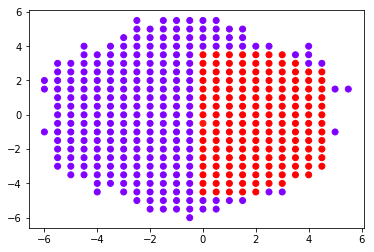

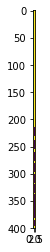

In [159]:
print(type(velcirc))
print(velcirc)
print(shape(data_stel_vel)[0])

print(float(velcirc[0]))
velcirc_mask=[]
for i in range(len(velcirc)):
    if (velcirc[i])==123456790:
        velcirc_mask.append('-100.0')
    else:
        velcirc_mask.append(str(velcirc[i]))
#print(velcirc_mask)
velcirc_mask=[float(y) for y in velcirc_mask]
cmap_here=plt.cm.rainbow(velcirc_mask)


print(len(velcirc_mask))
velcirc_mask=[float(y) for y in velcirc_mask]
plt.scatter(xs,ys,c=cmap_here)
#plt.colorbar()
plt.show()

plt.imshow(cmap_here)
plt.show()

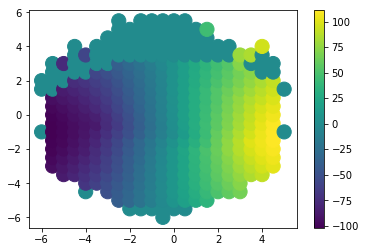

In [181]:
file='../MaNGA/kinemetry_output_8141_1901.txt'

with open(file, 'r') as f:
    data = f.readlines()
    title=[]
    xs=[]
    ys=[]
    output_vel=[]
   

    for x in data:
        words = x.split()
        if words[0] != '#':
            xs.append(words[1])
            ys.append(words[2])
            output_vel.append(words[3])
         
output_vel=[float(y) for y in output_vel]

plt.scatter(xs,ys,c=output_vel,s=200)
plt.colorbar()
plt.show()


len 400


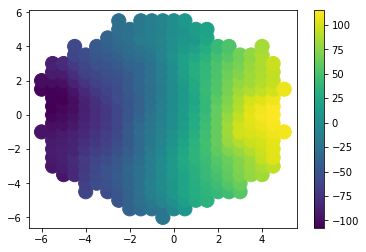

In [182]:
file='../MaNGA/kinemetry_input_8141-1901.txt'

with open(file, 'r') as f:
    data = f.readlines()
    title=[]
    xs=[]
    ys=[]
    input_vel=[]
   

    for x in data:
        words = x.split()
        if words[0] != '#':
            xs.append(words[1])
            ys.append(words[2])
            input_vel.append(words[3])
         
input_vel=[float(y) for y in input_vel]

#rgb=plt.cm.jet(float(input_vel))
print('len', len(input_vel))
plt.scatter(xs,ys,c=input_vel, s=200)
plt.colorbar()
plt.show()



0.0
(34, 34)
400
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
2

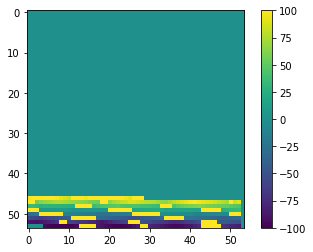

[[  0.         0.         0.       ..., -80.946943 -84.801627   0.      ]
 [-87.459469 -89.943158 -90.994447 ..., -49.65619  -51.497496   0.      ]
 [-54.058065 -56.784852 -61.196862 ..., -31.57987  -29.790166   0.      ]
 ..., 
 [  0.         0.         0.       ...,   0.         0.         0.      ]
 [  0.         0.         0.       ...,   0.         0.         0.      ]
 [  0.         0.         0.       ...,   0.         0.         0.      ]]


In [185]:
##step 1: make a new .txt file



path_spec='MaNGA_J0749/manga-8141-1901-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
b=pyfits.open(path_spec)
#print(b[0].header)





#b_stellar=pyfits.open('../MaNGA/'+plate+'/mangadap-'+plate+'-'+fiber+'-default.fits')
data_stel_vel=b['STELLAR_VEL'].data#'STELLAR_VEL'
data_stel_vel_ivar=b['STELLAR_VEL_IVAR'].data
data_stel_vel_mask=b['STELLAR_VEL_MASK'].data
data_stel_sig=np.sqrt(b['STELLAR_SIGMA'].data**2-b['STELLAR_SIGMACORR'].data**2)
data_stel_sig_ivar=b['STELLAR_SIGMA_IVAR'].data

print(velcirc[0])
#create an empty 2x2 array to populate with the model velocity
model_vel = np.zeros(shape=(shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
print(shape(model_vel))
print(len(velcirc))

##bins are binned by 0.5 units

'''You need to pull the position from the txt file because they are in order of XBIN YBIN'''
'''Practice on the txt file input because you know what its supposed to look like'''
n=0
'''for j in xrange(shape(data_stel_vel)[0]):
        for k in xrange(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
            sig=data_stel_sig[j][k]
            sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
            if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
            else:
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1'''
'''n=0
for j in range(20):
    for k in range(20):
        vel=data_stel_vel[j][k]
        vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
        sig=data_stel_sig[j][k]
        sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
        if vel==0.0 or vel_e > 10000 or sig_e > 10000:
            none=1
        else:
        xbin=(j-shape(data_stel_vel)[0]/2)
        ybin=(k-shape(data_stel_vel)[0]/2)
        #print('xbin,ybin', xbin,ybin)
        xbin_corr=xbin+34/2
        ybin_corr=ybin+34/2
        #print('corr', xbin_corr,ybin_corr)


        #print(n)
        print(xbin_corr, ybin_corr, n)
        model_vel[xbin_corr][ybin_corr]=velcirc[n]
        if velcirc[n] > 400000:
            model_vel[xbin_corr][ybin_corr]=0
        #if xbin**2+ybin**2 > 370:
        #    model_vel[xbin_corr][ybin_corr]=0
        #    print('xcor,ycor', xbin_corr, ybin_corr, ybin**2+xbin**2)
        if xbin_corr < 20 and ybin_corr > 35:
            model_vel[xbin_corr][ybin_corr]=0
        if ybin_corr <10:
            model_vel[xbin_corr][ybin_corr]=0
        if ybin_corr < 17 and xbin_corr < 11:
            model_vel[xbin_corr][ybin_corr]=0
        #ybin_corr >25 cuts off anything to the right of 0
        n+=1'''
                
model_vel = np.zeros(shape=(54,54))
         
                
for j in range(53):
    for k in range(53):
        xbin=(j)
        ybin=(k)
        #print('xbin,ybin', xbin,ybin)
        xbin_corr=xbin
        ybin_corr=ybin
            
            
        print(n)
        try:
            model_vel[xbin_corr][ybin_corr]=velcirc[n]
        except IndexError:
            continue
        n+=1
plt.clf()

plt.imshow(np.flipud(model_vel), vmin=-100, vmax=100)
plt.colorbar()
plt.show()
print(model_vel)

0.0
(34, 34)
400


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars


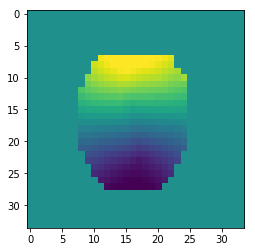

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [190]:
##step 1: make a new .txt file

print(velcirc[0])
#create an empty 2x2 array to populate with the model velocity
model_vel = np.zeros(shape=(shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
print(shape(model_vel))
print(len(velcirc))

##bins are binned by 0.5 units
n=0
'''for j in xrange(shape(data_stel_vel)[0]):
        for k in xrange(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
            sig=data_stel_sig[j][k]
            sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
            if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
            else:
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1'''
for j in range(shape(data_stel_vel)[0]):
    for k in range(shape(data_stel_vel)[0]):
        vel=data_stel_vel[j][k]
        vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
        sig=data_stel_sig[j][k]
        sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
        if vel==0.0 or vel_e > 10000 or sig_e > 10000:
            none=1
        else:
            xbin=(j-shape(data_stel_vel)[0]/2)
            ybin=(k-shape(data_stel_vel)[0]/2)
            #print('xbin,ybin', xbin,ybin)
            xbin_corr=xbin+54/2
            ybin_corr=ybin+54/2
            
            
            xbin_corr=j
            ybin_corr=k
            
            
            #print(n)
            try:
                model_vel[xbin_corr][ybin_corr]=velcirc[n]
                if velcirc[n] > 40000:
                    model_vel[xbin_corr][ybin_corr]=0
                #if xbin**2+ybin**2 > 370:
                #    model_vel[xbin_corr][ybin_corr]=0
                #    print('xcor,ycor', xbin_corr, ybin_corr, ybin**2+xbin**2)
                '''if xbin_corr < 20 and ybin_corr > 35:
                    model_vel[xbin_corr][ybin_corr]=0
                if ybin_corr <10:
                    model_vel[xbin_corr][ybin_corr]=0
                if ybin_corr < 17 and xbin_corr < 11:
                    model_vel[xbin_corr][ybin_corr]=0'''
                #ybin_corr >25 cuts off anything to the right of 0
                n+=1
            except IndexError:
                n+=1 
                continue
plt.clf()
plt.imshow(np.flipud(model_vel), vmin=-100, vmax=100)
plt.show()
print(model_vel)

In [232]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print(data_stel_vel)
print(masked_stel_vel)
#masked_stel_vel_model=ma.masked_where(abs(model_vel) > 10000 , model_vel)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
#masked_stel_vel_model=ma.masked_where(model_vel ==0, masked_stel_vel_model)
masked_stel_vel_data=ma.masked_where(model_vel==0, model_vel)
masked_stel=ma.masked_where(data_stel_vel< -150, data_stel_vel)
##masked_stel_vel_model=ma.masked_where(model_vel ==0, masked_stel_vel_model)
##masked_stel_vel=ma.masked_where(abs((1/np.sqrt(data_stel_vel_ivar))/data_stel_vel) > 1.0, abs(data_stel_vel) > 100, masked_stel_vel)
im=ax.imshow(masked_stel-masked_stel_vel_data, vmin=-50,vmax=50,  cmap='rainbow')#,vmin=-25,vmax=25)#, vmin=-100, vmax=100)#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel), interpolation='None')#, vmin=-300, vmax=300)
'''-(masked_stel_vel_model-masked_stel_vel)'''
#print(max(masked_stel_vel))
ax.set_adjustable('box-forced')
ax.annotate('Residuals', xy=(0.05,0.92),xycoords='axes fraction', size=15)

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(model_vel)/2,10)
middle=len(model_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)
    
x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=15)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=15)

#plt.title(r'Stellar Velocity [km s$^{-1}$]')
#im=plt.imshow(np.flipud(data_stel_vel), vmin=-300, vmax=300)
#ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)

#if circle=='yes':
#    ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')
#cbar1.ax.set_ticks([-150,-100,50,0,50,100,150])
#colorbar(im)
cbar1.set_label(label=r'Stellar Velocity [km s$^{-1}$]',size=15,weight='normal', labelpad=10)
plt.xlim([0,len(model_vel)])
plt.ylim([0,len(model_vel)])
plt.xlabel('Arcsec', size=15)
plt.ylabel('Arcsec', size=15)
plt.tight_layout()
#plt.show()
savefig('../stellar-vel-resids-8141-1901.pdf')
        

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


In [217]:
'''velcirc for oiii'''
velcirc_oiii=[   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       94.566624
,
       98.440350
,
       100.77599
,
       101.66244
,
       100.88470
,
       98.499185
,
       94.708075
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       87.659005
,
       94.309980
,
       100.10556
,
       104.55457
,
       107.34515
,
       108.37909
,
       107.49426
,
       104.75749
,
       100.28463
,
       94.609005
,
       87.998403
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       82.746515
,
       91.028455
,
       98.573145
,
       105.50298
,
       110.84881
,
       114.42932
,
       115.69890
,
       114.28889
,
       110.49755
,
       105.34282
,
       98.795274
,
       91.116432
,
       82.906861
,
   1.2345679e+08
,
   1.2345679e+08
,
       74.949359
,
       84.023975
,
       92.922936
,
       101.18333
,
       109.63944
,
       116.82071
,
       121.49458
,
       123.02519
,
       121.28945
,
       116.38074
,
       109.87093
,
       101.89362
,
       93.001120
,
       84.172195
,
       75.211584
,
   1.2345679e+08
,
   1.2345679e+08
,
       64.699989
,
       74.117629
,
       83.398805
,
       92.115864
,
       102.64572
,
       112.46536
,
       121.42672
,
       126.96564
,
       129.47073
,
       127.45659
,
       121.60232
,
       112.80278
,
       102.38259
,
       92.188041
,
       83.352044
,
       74.288304
,
       65.291623
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       61.351096
,
       70.814834
,
       79.029369
,
       88.989797
,
       100.69308
,
       113.67770
,
       124.48000
,
       132.34548
,
       133.76920
,
       132.35073
,
       124.68125
,
       113.67942
,
       100.53541
,
       89.012923
,
       78.237787
,
       70.613560
,
       61.897454
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       49.363221
,
       56.781811
,
       63.691547
,
       70.987227
,
       82.311128
,
       96.483887
,
       108.57315
,
       113.08385
,
       119.48883
,
       123.35583
,
       119.51732
,
       113.13547
,
       108.53446
,
       95.375060
,
       82.127544
,
       71.436459
,
       63.090396
,
       56.534606
,
       49.481973
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       43.144901
,
       47.867704
,
       52.904661
,
       60.046259
,
       71.087603
,
       83.443395
,
       87.510891
,
       91.168296
,
       99.678877
,
       105.84685
,
       99.667443
,
       91.564908
,
       87.492766
,
       83.467073
,
       71.861531
,
       59.985519
,
       52.557613
,
       48.266648
,
       42.762195
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       34.904519
,
       37.436427
,
       38.976034
,
       45.078007
,
       54.986640
,
       60.399034
,
       62.964892
,
       66.057017
,
       72.682871
,
       75.723426
,
       72.786048
,
       66.385031
,
       62.958708
,
       60.419231
,
       55.369669
,
       44.862529
,
       39.350017
,
       36.938892
,
       34.238285
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
       23.803322
,
       25.354867
,
       24.601528
,
       24.147573
,
       29.704550
,
       33.965593
,
       35.317153
,
       38.153961
,
       41.309495
,
       44.465028
,
       48.337431
,
       44.517232
,
       41.506842
,
       38.496452
,
       35.486062
,
       33.971366
,
       26.774035
,
       23.959637
,
       23.932167
,
       24.858782
,
       24.364786
,
   1.2345679e+08
,
   1.2345679e+08
,
       16.020650
,
       15.162752
,
       11.124659
,
       7.6205688
,
       9.4258221
,
       9.5366475
,
       10.909089
,
       12.281531
,
       13.653973
,
       15.026415
,
       16.049999
,
       15.026892
,
       13.655901
,
       12.284911
,
       10.913920
,
       9.5429292
,
       9.3068634
,
       7.8223971
,
       12.846175
,
       15.414233
,
       16.655987
,
   1.2345679e+08
,
   1.2345679e+08
,
       8.2725476
,
       5.0955924
,
      -1.6802395
,
      -8.4203704
,
      -11.055315
,
      -15.183271
,
      -15.108911
,
      -15.034552
,
      -14.960192
,
      -14.826313
,
      -16.764744
,
      -14.780442
,
      -14.960023
,
      -15.034305
,
      -15.108588
,
      -15.182870
,
      -11.413168
,
      -8.0773420
,
     -0.14806616
,
       5.4063478
,
       8.8983082
,
   1.2345679e+08
,
   1.2345679e+08
,
      -4.0937752
,
      -12.571004
,
      -22.600891
,
      -30.004393
,
      -36.368376
,
      -39.699625
,
      -39.627768
,
      -41.579946
,
      -43.766758
,
      -44.770270
,
      -43.696983
,
      -41.358122
,
      -39.628167
,
      -39.699560
,
      -36.503018
,
      -30.204903
,
      -21.894039
,
      -11.546278
,
      -3.6413375
,
   1.2345679e+08
,
   1.2345679e+08
,
      -11.730705
,
      -20.057130
,
      -31.688064
,
      -44.397901
,
      -54.313889
,
      -64.469800
,
      -65.589516
,
      -66.611493
,
      -71.015232
,
      -74.893697
,
      -70.837826
,
      -66.610071
,
      -65.582617
,
      -64.472053
,
      -54.494753
,
      -44.417804
,
      -32.544740
,
      -20.225941
,
      -11.137646
,
   1.2345679e+08
,
      -17.507188
,
      -26.305303
,
      -38.644304
,
      -54.221131
,
      -67.036815
,
      -78.211008
,
      -89.072193
,
      -91.157026
,
      -94.670502
,
      -96.927699
,
      -94.683427
,
      -91.158523
,
      -89.062084
,
      -77.928989
,
      -66.299321
,
      -53.651456
,
      -39.361487
,
      -26.452204
,
   1.2345679e+08
,
      -30.903984
,
      -41.919415
,
      -57.135481
,
      -73.146849
,
      -85.319993
,
      -95.443599
,
      -106.32314
,
      -113.62958
,
      -114.41140
,
      -113.69354
,
      -106.41262
,
      -95.192539
,
      -85.417898
,
      -73.022832
,
      -56.632528
,
      -41.805872
,
      -30.830495
,
   1.2345679e+08
,
      -33.131641
,
      -43.447637
,
      -55.712970
,
      -69.698181
,
      -85.057683
,
      -97.531354
,
      -105.54015
,
      -110.77506
,
      -113.08693
,
      -110.89930
,
      -105.07192
,
      -97.129276
,
      -85.499622
,
      -70.496591
,
      -55.735566
,
      -43.129630
,
      -43.383490
,
      -53.758037
,
      -64.359921
,
      -77.742255
,
      -89.354435
,
      -98.837451
,
      -105.15437
,
      -107.99452
,
      -105.64209
,
      -99.012248
,
      -88.894233
,
      -76.705711
,
      -64.454784
,
      -53.584614
,
      -42.830599
,
   1.2345679e+08
,
      -50.979288
,
      -60.324580
,
      -68.638132
,
      -77.137660
,
      -85.103650
,
      -89.928319
,
      -92.240859
,
      -90.367983
,
      -85.133457
,
      -77.243245
,
      -68.712909
,
      -60.021634
,
      -50.788266
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -58.019585
,
      -64.176124
,
      -70.332662
,
      -76.130017
,
      -78.185329
,
      -77.316318
,
      -74.167093
,
      -69.127177
,
      -62.800036
,
      -55.115662
,
   1.2345679e+08
,
   1.2345679e+08
,
      -62.005900
,
   1.2345679e+08]

(34, 34)
400


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


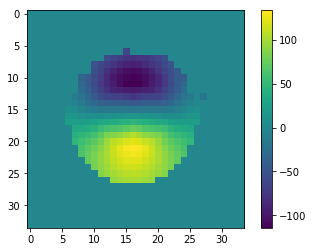

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [220]:

#create an empty 2x2 array to populate with the model velocity
model_vel_oiii = np.zeros(shape=(shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
print(shape(model_vel_oiii))
print(len(velcirc))

##bins are binned by 0.5 units
n=0
for j in range(shape(data_stel_vel)[0]):
    for k in range(shape(data_stel_vel)[0]):
        vel=data_stel_vel[j][k]
        vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
        sig=data_stel_sig[j][k]
        sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
        if vel==0.0 or vel_e > 10000 or sig_e > 10000:
            none=1
        else:
            xbin=(j-shape(data_stel_vel)[0]/2)
            ybin=(k-shape(data_stel_vel)[0]/2)
            #print('xbin,ybin', xbin,ybin)
            xbin_corr=xbin+54/2
            ybin_corr=ybin+54/2
            
            
            xbin_corr=j
            ybin_corr=k
            
            
            #print(n)
            try:
                model_vel_oiii[xbin_corr][ybin_corr]=velcirc_oiii[n]
                if velcirc_oiii[n] > 40000:
                    model_vel_oiii[xbin_corr][ybin_corr]=0
                #if xbin**2+ybin**2 > 370:
                #    model_vel[xbin_corr][ybin_corr]=0
                #    print('xcor,ycor', xbin_corr, ybin_corr, ybin**2+xbin**2)
                '''if xbin_corr < 20 and ybin_corr > 35:
                    model_vel[xbin_corr][ybin_corr]=0
                if ybin_corr <10:
                    model_vel[xbin_corr][ybin_corr]=0
                if ybin_corr < 17 and xbin_corr < 11:
                    model_vel[xbin_corr][ybin_corr]=0'''
                #ybin_corr >25 cuts off anything to the right of 0
                n+=1
            except IndexError:
                n+=1 
                continue
plt.clf()
plt.imshow(np.flipud(model_vel_oiii))
plt.colorbar()
plt.show()

print(model_vel)

In [231]:
'''Make some beautiful plots for the OIII modeling :)'''


path_spec='MaNGA_J0749/manga-8141-1901-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
b=pyfits.open(path_spec)
#print(b[0].header)



#print(b_stellar[0].header)
elines_vel=b['EMLINE_GVEL'].data

oiii_elines=elines_vel[3]


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print(data_stel_vel)
print(masked_stel_vel)
#masked_stel_vel_model=ma.masked_where(abs(model_vel) > 10000 , model_vel)#(1/np.sqrt(data_stel_vel_ivar))/data_stel_vel > 1.0
#masked_stel_vel_model=ma.masked_where(model_vel ==0, masked_stel_vel_model)
masked_stel_vel_data=ma.masked_where(model_vel_oiii==0, model_vel_oiii)
masked_stel=ma.masked_where(data_stel_vel< -150, oiii_elines)
##masked_stel_vel_model=ma.masked_where(model_vel ==0, masked_stel_vel_model)
##masked_stel_vel=ma.masked_where(abs((1/np.sqrt(data_stel_vel_ivar))/data_stel_vel) > 1.0, abs(data_stel_vel) > 100, masked_stel_vel)
im=ax.imshow(masked_stel-masked_stel_vel_data,vmin=-50,vmax=50,  cmap='rainbow')#,vmin=-25,vmax=25)#, vmin=-100, vmax=100)#,vmin=-max(masked_stel_vel), vmax=max(masked_stel_vel), interpolation='None')#, vmin=-300, vmax=300)
'''-(masked_stel_vel_model-masked_stel_vel)'''
#print(max(masked_stel_vel))
ax.set_adjustable('box-forced')
ax.annotate('Residuals', xy=(0.05,0.92),xycoords='axes fraction', size=15)

ax.get_yaxis().set_ticks_position("left")
ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
#put ticks every 5

x_ticks=np.arange(0,len(model_vel)/2,10)
middle=len(model_vel)/2
#print('total locs', len(data_stel_vel),'x_tick_locs', x_tick_locs)
    
x_tick_locs_neg=[middle-x for x in x_ticks]
x_tick_locs_pos=[middle+x for x in x_ticks]
x_tick_locs=np.concatenate([x_tick_locs_neg, x_tick_locs_pos])

x_tick_lbls=[int((x-middle)*0.5) for x in x_tick_locs]
y_tick_lbls=[-x for x in x_tick_lbls]

ax.xaxis.set_ticks(x_tick_locs)
ax.xaxis.set_ticklabels(x_tick_lbls, size=15)

ax.yaxis.set_ticks(x_tick_locs)
ax.yaxis.set_ticklabels(y_tick_lbls, size=15)

#plt.title(r'Stellar Velocity [km s$^{-1}$]')
#im=plt.imshow(np.flipud(data_stel_vel), vmin=-300, vmax=300)
#ax.scatter(popt[1], popt[2], color='black', marker='x', s=100)

#if circle=='yes':
#    ax.scatter(x_coord,y_coord, s=200,facecolors='none', edgecolors='black')
cbar1=colorbar(im)
cbar1.ax.tick_params(labelsize=20, direction='out')
#cbar1.ax.set_ticks([-150,-100,50,0,50,100,150])
#colorbar(im)
cbar1.set_label(label=r'Stellar Velocity [km s$^{-1}$]',size=15,weight='normal', labelpad=10)
plt.xlim([0,len(model_vel)])
plt.ylim([0,len(model_vel)])
plt.xlabel('Arcsec', size=15)
plt.ylabel('Arcsec', size=15)
plt.tight_layout()
#plt.show()
savefig('../gas-vel-resids-8141-1901.pdf')
        



[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]
